# Классификация данных Speedtest
В рамках данного ноутбука поработаем непосредственно с обработанными данными.

## Подготовка к работе
Оптимизируем дальнейший код и сразу заполним пространство всем необходимым функционалом.

In [1]:
import os
import pandas as pd
import numpy as np
import tensorflow as tf

import seaborn as sns
from matplotlib import pyplot as plt

2023-05-13 21:13:09.022838: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-13 21:13:09.857170: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
def check_folder_name(folder_name: str) -> str:
    """If folder not exists - create, after return path"""

    if not os.path.exists(folder_name):
        os.makedirs(folder_name)

    return folder_name

In [3]:
SEED = 0  # to reproduce building
BATCH_SIZE = 16

FIG_SIZE = (38.4,21.6)  # 3810x2160

DATA_PATH = 'data/light'
LOGS_PATH = check_folder_name('logs/light')
VISUAL_PATH = check_folder_name('visual/model/light')
MODEL_PATH = check_folder_name('model/light')

In [4]:
sns.set_theme(palette='winter', font='jost', font_scale=3, rc={'figure.figsize': FIG_SIZE})

### Подготовка датасета
Загрузим датасет, отсортируем значения по годам и уровню ВВП и уберём лишние признаки

In [5]:
df = pd.read_csv(f'{DATA_PATH}/fixed/fixed_light.csv').sort_values(by=['year', 'income'])
df.head()

,iso_a3,year,label,income,group,continent,avg_d_kbps,avg_u_kbps,avg_lat_ms,tests,devices
724,VEN,2019,Venezuela,84.341190,Low income,South America,2488.000,746.250,147.000000,433441,102768
616,SSD,2019,"South Sudan, Republic of",341.546923,Low income,Africa,1488.375,697.000,688.500000,889,308
752,ZWE,2019,Zimbabwe,369.445017,Low income,Africa,7779.750,4636.625,26.500000,20461,7358
44,BDI,2019,Burundi,745.616556,Low income,Africa,7248.500,7556.250,27.000000,2272,727
112,CAF,2019,Central African Republic,1005.373469,Low income,Africa,1071.500,1191.875,401.583333,159,85


Сбалансируем датасет, приведя группы к единому размеру и сократив его до 200 000 наблюдений на группу

In [6]:
df.groupby('group').describe().T

group              High income    Low income  Lower-middle income  \
year       count  1.850000e+02  1.930000e+02         1.850000e+02   
           mean   2.020573e+03  2.020477e+03         2.020508e+03   
           std    1.135554e+00  1.123019e+00         1.099006e+00   
           min    2.019000e+03  2.019000e+03         2.019000e+03   
           25%    2.020000e+03  2.019000e+03         2.020000e+03   
           50%    2.021000e+03  2.020000e+03         2.020000e+03   
           75%    2.022000e+03  2.021000e+03         2.021000e+03   
           max    2.022000e+03  2.022000e+03         2.022000e+03   
income     count  1.850000e+02  1.930000e+02         1.850000e+02   
           mean   5.595205e+04  2.523886e+03         9.072080e+03   
           std    2.055219e+04  1.218700e+03         2.739538e+03   
           min    3.377065e+04  8.434119e+01         4.803711e+03   
           25%    4.224927e+04  1.547549e+03         6.207104e+03   
           50%    5.164086e+04  2.355433e+03         9.178991e+03   
           75%    6.061899e+04  3.512199e+03         1.155625e+04   
           max    1.300029e+05  4.790261e+03         1.351237e+04   
avg_d_kbps count  1.850000e+02  1.930000e+02         1.850000e+02   
           mean   6.562443e+04  7.562682e+03         1.393767e+04   
           std    4.419483e+04  5.497072e+03         1.064165e+04   
           min    7.564125e+03  1.071500e+03         2.156000e+03   
           25%    3.147675e+04  3.755500e+03         7.173000e+03   
           50%    5.454800e+04  6.011000e+03         9.944000e+03   
           75%    8.732500e+04  9.381000e+03         1.706400e+04   
           max    2.479582e+05  3.047300e+04         6.709650e+04   
avg_u_kbps count  1.850000e+02  1.930000e+02         1.850000e+02   
           mean   3.606136e+04  4.805806e+03         9.905878e+03   
           std    4.060348e+04  4.745026e+03         1.100152e+04   
           min    2.303250e+03  2.820000e+02         5.893750e+02   
           25%    1.066925e+04  2.374500e+03         2.780000e+03   
           50%    1.775825e+04  3.783500e+03         5.647000e+03   
           75%    4.529800e+04  5.335000e+03         1.212850e+04   
           max    2.153611e+05  3.070712e+04         5.360788e+04   
avg_lat_ms count  1.850000e+02  1.930000e+02         1.850000e+02   
           mean   1.537365e+01  1.061572e+02         3.058446e+01   
           std    7.637106e+00  1.863260e+02         3.025751e+01   
           min    4.000000e+00  6.750000e+00         4.500000e+00   
           25%    9.500000e+00  2.500000e+01         1.575000e+01   
           50%    1.400000e+01  3.633333e+01         2.370833e+01   
           75%    1.950000e+01  7.200000e+01         3.600000e+01   
           max    5.266667e+01  8.190000e+02         2.143333e+02   
tests      count  1.850000e+02  1.930000e+02         1.850000e+02   
           mean   5.001193e+06  8.876065e+04         2.555902e+06   
           std    1.343775e+07  3.155366e+05         7.274002e+06   
           min    7.031000e+03  1.200000e+01         4.100000e+01   
           25%    3.177520e+05  2.280000e+03         2.654100e+04   
           50%    1.255874e+06  7.178000e+03         3.509340e+05   
           75%    3.359471e+06  2.741700e+04         1.344481e+06   
           max    1.065139e+08  2.660579e+06         5.079205e+07   
devices    count  1.850000e+02  1.930000e+02         1.850000e+02   
           mean   1.410792e+06  2.129335e+04         6.018233e+05   
           std    3.893063e+06  6.766588e+04         1.590577e+06   
           min    2.718000e+03  5.000000e+00         2.100000e+01   
           25%    1.019610e+05  6.690000e+02         9.131000e+03   
           50%    3.472270e+05  2.257000e+03         8.842800e+04   
           75%    9.862430e+05  7.288000e+03         3.354400e+05   
           max    2.936323e+07  5.124650e+05         1.117918e+07   

group             Upper-middle income  
year       count         1

Категоризируем целевой признак `group`

In [7]:
values, groups = pd.factorize(df.pop('group'))
df['group'] = values

print('\n'.join(f'{n} - {v}' for n, v in enumerate(groups)))

0 - Low income
1 - Lower-middle income
2 - Upper-middle income
3 - High income


Категоризируем качественный признак `continent` и переведём его в dummy-переменную

In [8]:
values, continents = pd.factorize(df.pop('continent'))
df = pd.concat([df, pd.DataFrame(tf.keras.utils.to_categorical(values, dtype='int8'), index=df.index, columns=continents)], axis=1)

print('\n'.join(f'{n} - {v}' for n, v in enumerate(continents)))

0 - South America
1 - Africa
2 - Oceania
3 - Asia
4 - North America
5 - Europe
6 - Seven seas (open ocean)


Уберём лишние колонки и перетасуем полученный датасет

In [9]:
df = df.drop(columns=['iso_a3', 'label', 'income']).sample(frac=1)
df.head()

,year,avg_d_kbps,avg_u_kbps,avg_lat_ms,tests,devices,group,South America,Africa,Oceania,Asia,North America,Europe,Seven seas (open ocean)
557,2020,7642.500,4986.750,21.000,816733,210027,1,1,0,0,0,0,0,0
18,2021,160116.875,91889.250,6.000,2807802,922414,3,0,0,0,1,0,0,0
687,2022,19814.375,5319.875,19.000,5638102,1748674,2,0,0,0,1,0,0,0
29,2020,10406.625,1097.875,50.375,51033,10713,2,0,0,0,0,1,0,0
350,2021,8646.750,8474.000,25.500,350934,71634,1,0,1,0,0,0,0,0


Построим корреляционную матрицу и посмотрим, как коррелируют полученные признаки друг с другом

In [10]:
fixed_correlation = df.corr(method='spearman').round(2)
fixed_correlation

,year,avg_d_kbps,avg_u_kbps,avg_lat_ms,tests,devices,group,South America,Africa,Oceania,Asia,North America,Europe,Seven seas (open ocean)
year,1.00,0.25,0.22,-0.23,0.05,0.04,0.02,0.00,0.00,0.00,0.00,0.00,0.00,0.00
avg_d_kbps,0.25,1.00,0.86,-0.79,0.50,0.52,0.72,-0.07,-0.53,-0.17,0.16,0.16,0.44,0.01
avg_u_kbps,0.22,0.86,1.00,-0.80,0.41,0.43,0.54,-0.06,-0.45,-0.17,0.24,0.03,0.35,0.06
avg_lat_ms,-0.23,-0.79,-0.80,1.00,-0.37,-0.39,-0.52,0.03,0.46,0.27,-0.20,-0.08,-0.37,-0.16
tests,0.05,0.50,0.41,-0.37,1.00,1.00,0.57,0.18,-0.47,-0.32,0.30,0.03,0.30,-0.07
devices,0.04,0.52,0.43,-0.39,1.00,1.00,0.59,0.18,-0.49,-0.32,0.30,0.02,0.32,-0.07
group,0.02,0.72,0.54,-0.52,0.57,0.59,1.00,-0.01,-0.58,-0.16,0.14,0.11,0.49,0.07
South America,0.00,-0.07,-0.06,0.03,0.18,0.18,-0.01,1.00,-0.16,-0.07,-0.15,-0.10,-0.13,-0.03
Africa,0.00,-0.53,-0.45,0.46,-0.47,-0.49,-0.58,-0.16,1.00,-0.17,-0.34,-0.23,-0.31,-0.08
Oceania,0.00,-0.17,-0.17,0.27,-0.32,-0.32,-0.16,-0.07,-0.17,1.00,-0.16,-0.11,-0.14,-0.04


Выведем данную матрицу на тепловую карту

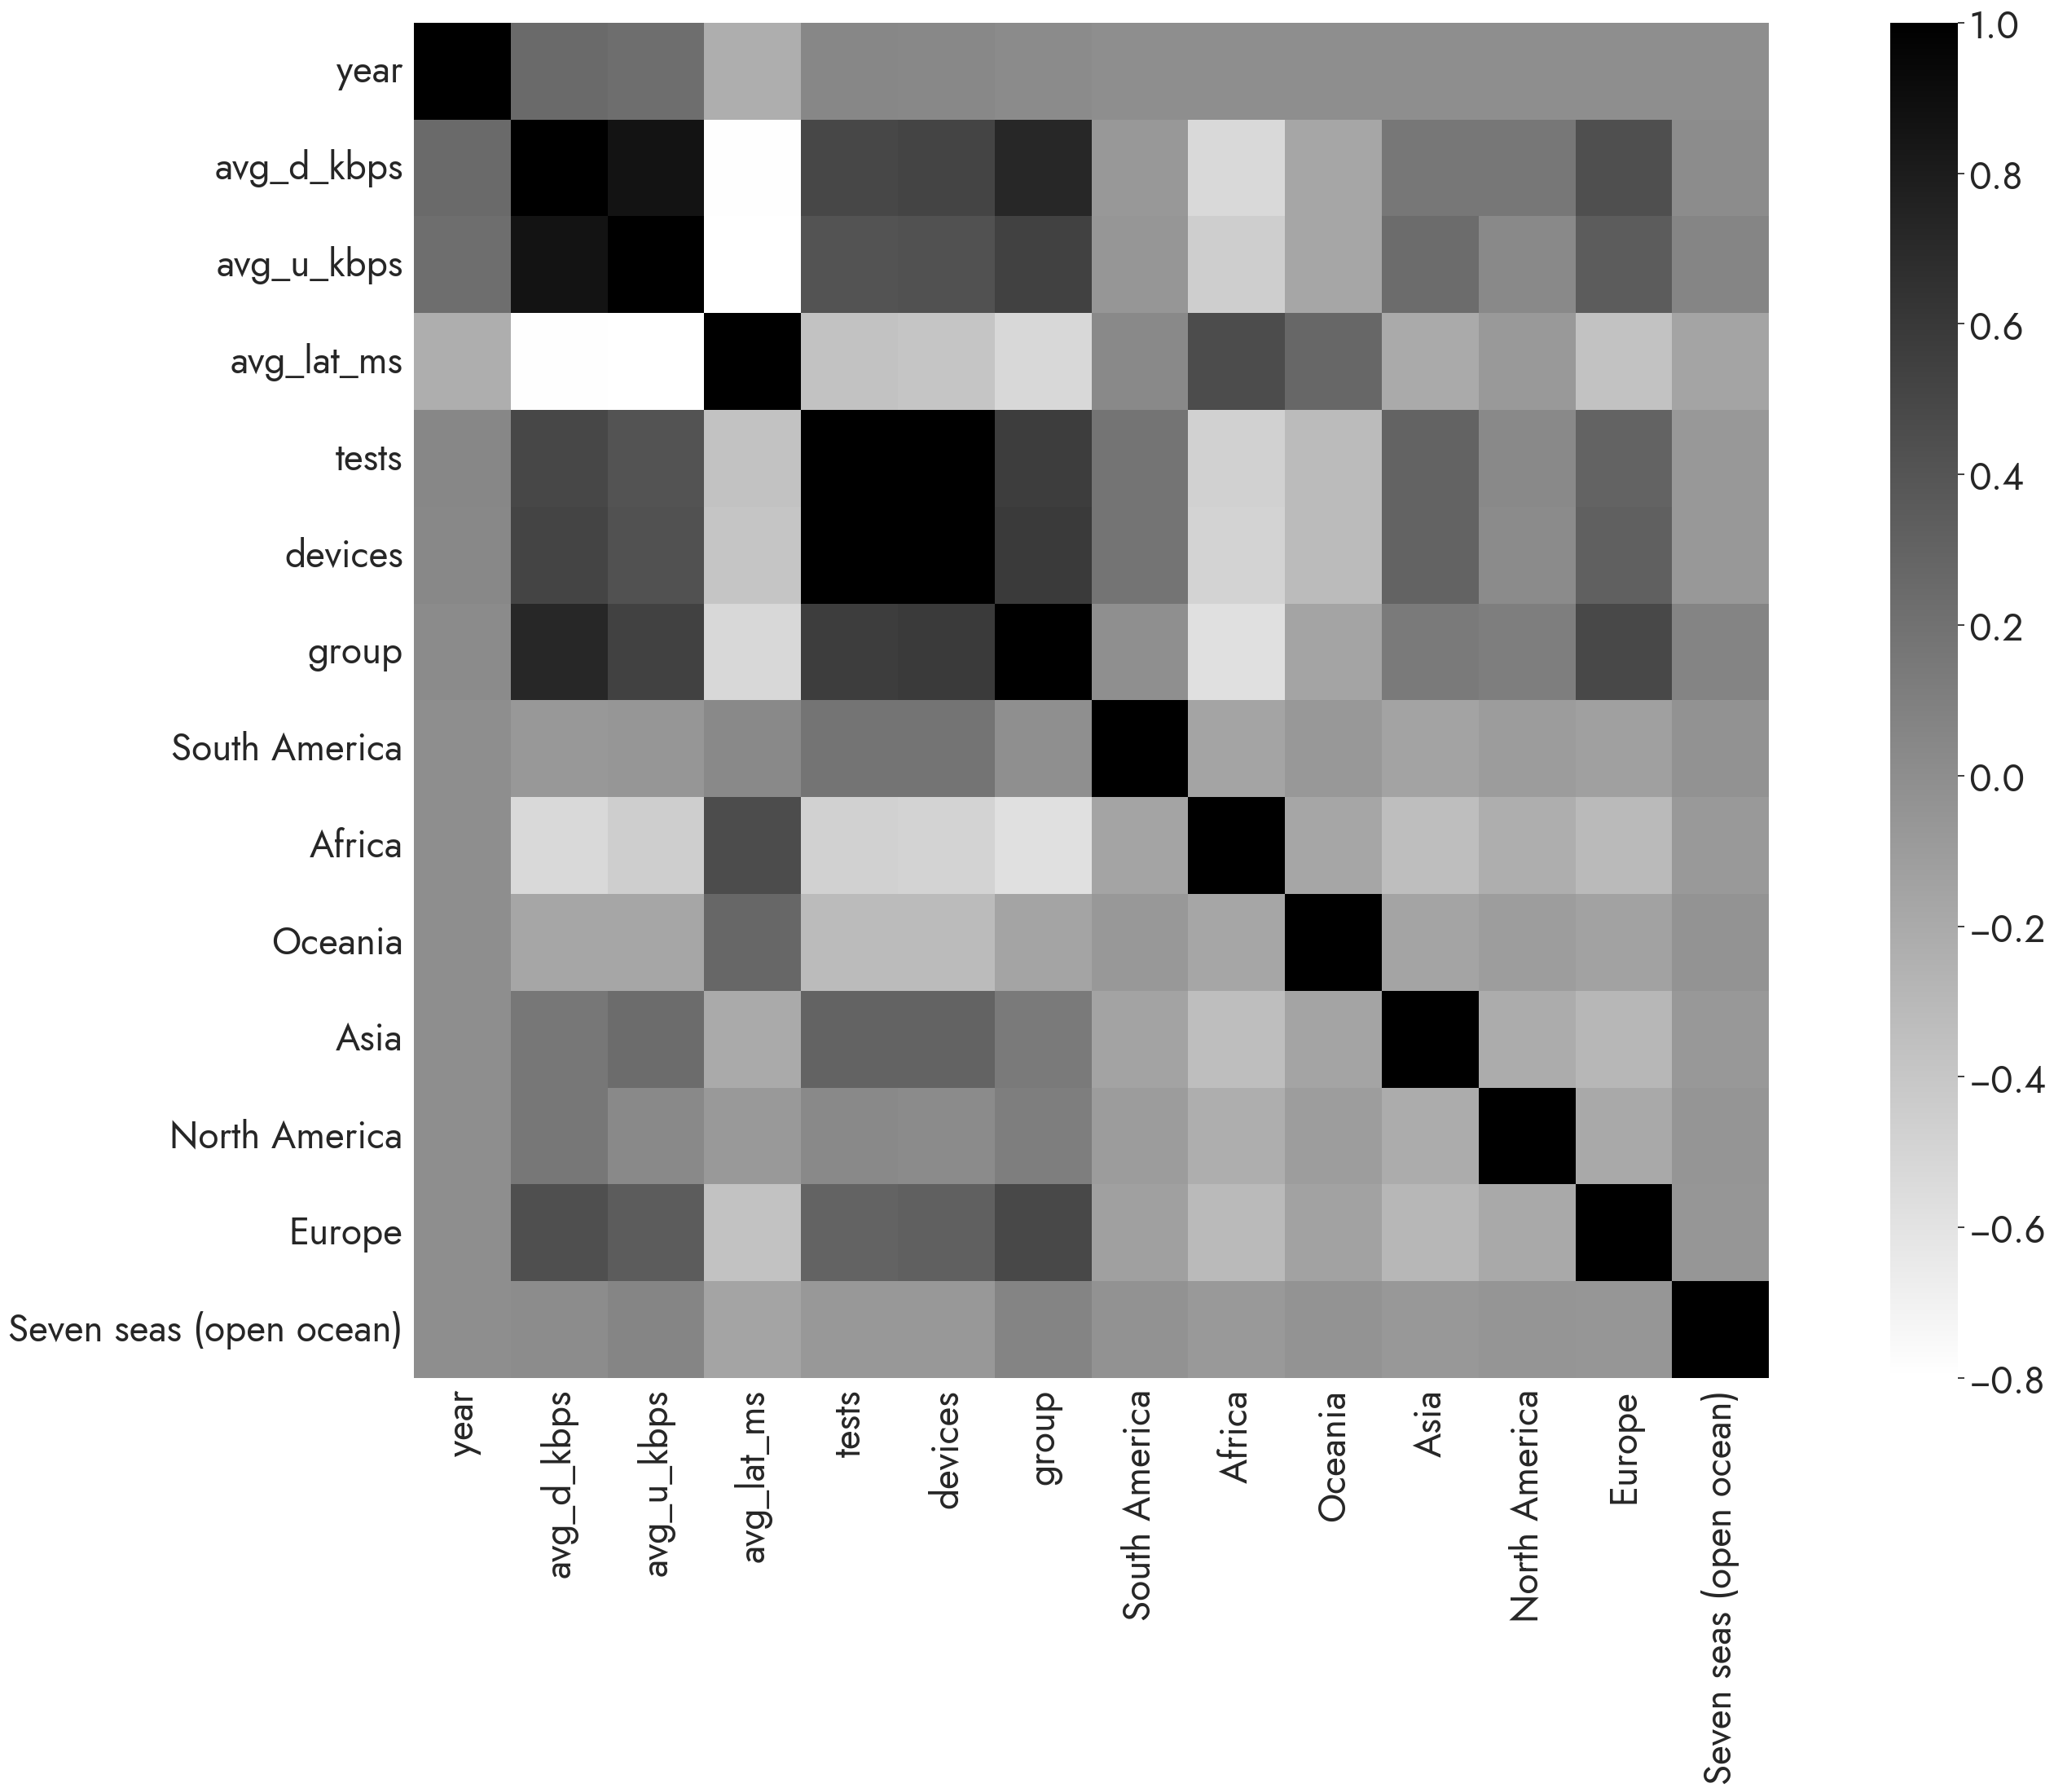

In [11]:
fixed_plot_correlation = sns.heatmap(fixed_correlation, cmap='gray_r', square=True);

In [12]:
fixed_plot_correlation.figure.savefig(f'{VISUAL_PATH}/fixed_correlation.png', transparent=True)

Разделим датасет на обучающий набор - 80%, и на тестовый - 20%

In [13]:
train_df = df.sample(frac=0.8, random_state=SEED)
test_df = df.drop(train_df.index)

print(len(train_df), 'training examples')
print(len(test_df), 'testing examples')

605 training examples
151 testing examples


Выделим целевой признак и преобразуем его в бинарную dummy-переменную

In [14]:
train_features = train_df
train_target = tf.keras.utils.to_categorical(train_features.pop('group'), dtype='int8')

In [15]:
test_features = test_df
test_target = tf.keras.utils.to_categorical(test_features.pop('group'), dtype='int8')

Из ноутбука с визуализацией было выяснено, что признаки выраженное левостороннее распределение.
Создадим слой для их нормализации и подгоним его состояние предварительной обработки к признакам

In [16]:
normalize = tf.keras.layers.Normalization()
normalize.adapt(train_features, batch_size=BATCH_SIZE)

2023-05-13 21:13:12.361436: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-05-13 21:13:12.562360: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-05-13 21:13:12.562427: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-05-13 21:13:12.566318: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-05-13 21:13:12.566436: I tensorflow/compile

## Анализ данных

### Настройка моделей
В дальнейшем предполагается построение нескольких моделей, различающихся по крупности.
Напишем общую функцию их настройки и обучения:
* optimizer - формула, по которой происходит оптимизация модели
* loss - формула, по которой рассчитываются ошибки предсказаний модели
* batch_size - размер совокупности наблюдений, по которым модель обучается за раз
* callbacks - дополнительные параметры, в данном случае отвечающие за остановку обучения в случае минимальных изменений от эпохи, а также за запись процесса обучения

In [17]:
def compile_and_fit(model: tf.keras.Sequential, max_epochs: int = 100):
    model.compile(
        optimizer=tf.keras.optimizers.Adam(),
        loss=tf.keras.losses.CategoricalCrossentropy(),
        metrics=[
            tf.keras.metrics.CategoricalAccuracy(name='accuracy')
        ],
    )

    model.summary()

    history = model.fit(
        train_features, train_target,
        batch_size=BATCH_SIZE,
        validation_split=0.2,  # 20% of train data will validate model
        epochs=max_epochs,  # amount model trains
        verbose=2,
        callbacks=[
            tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0.001, patience=5, verbose=1, start_from_epoch=10),
            tf.keras.callbacks.TensorBoard(f'{LOGS_PATH}/{model.name}'),
        ],
    )

    return history.history

### Линейная модель
Начнём с самой простой модели, содержащей только слой нормализации и выходной - линейной модели

In [18]:
linear_model = tf.keras.Sequential(
    [
        normalize,
        tf.keras.layers.Dense(train_target.shape[1], activation=tf.keras.activations.softmax),
    ],
    name='linear'
)

In [19]:
linear_history = compile_and_fit(linear_model)

Model: "linear"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization (Normalizatio  (None, 13)               27        
 n)                                                              
                                                                 
 dense (Dense)               (None, 4)                 56        
                                                                 
Total params: 83
Trainable params: 56
Non-trainable params: 27
_________________________________________________________________
Epoch 1/100


2023-05-13 21:13:15.660256: I tensorflow/compiler/xla/service/service.cc:169] XLA service 0x370acdc0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-05-13 21:13:15.660300: I tensorflow/compiler/xla/service/service.cc:177]   StreamExecutor device (0): NVIDIA GeForce RTX 2060, Compute Capability 7.5
2023-05-13 21:13:15.678920: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-05-13 21:13:17.704297: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:424] Loaded cuDNN version 8901
2023-05-13 21:13:18.000011: I ./tensorflow/compiler/jit/device_compiler.h:180] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


31/31 - 4s - loss: 1.6700 - accuracy: 0.2190 - val_loss: 1.6382 - val_accuracy: 0.2149 - 4s/epoch - 131ms/step
Epoch 2/100
31/31 - 0s - loss: 1.5913 - accuracy: 0.2376 - val_loss: 1.5589 - val_accuracy: 0.2727 - 183ms/epoch - 6ms/step
Epoch 3/100
31/31 - 0s - loss: 1.5205 - accuracy: 0.3202 - val_loss: 1.4877 - val_accuracy: 0.4050 - 219ms/epoch - 7ms/step
Epoch 4/100
31/31 - 0s - loss: 1.4570 - accuracy: 0.4112 - val_loss: 1.4272 - val_accuracy: 0.4298 - 181ms/epoch - 6ms/step
Epoch 5/100
31/31 - 0s - loss: 1.4030 - accuracy: 0.4194 - val_loss: 1.3707 - val_accuracy: 0.4463 - 168ms/epoch - 5ms/step
Epoch 6/100
31/31 - 0s - loss: 1.3535 - accuracy: 0.4318 - val_loss: 1.3215 - val_accuracy: 0.4545 - 161ms/epoch - 5ms/step
Epoch 7/100
31/31 - 0s - loss: 1.3098 - accuracy: 0.4483 - val_loss: 1.2789 - val_accuracy: 0.4463 - 180ms/epoch - 6ms/step
Epoch 8/100
31/31 - 0s - loss: 1.2723 - accuracy: 0.4587 - val_loss: 1.2406 - val_accuracy: 0.4628 - 187ms/epoch - 6ms/step
Epoch 9/100
31/31 - 0

Визуализируем ход обучения

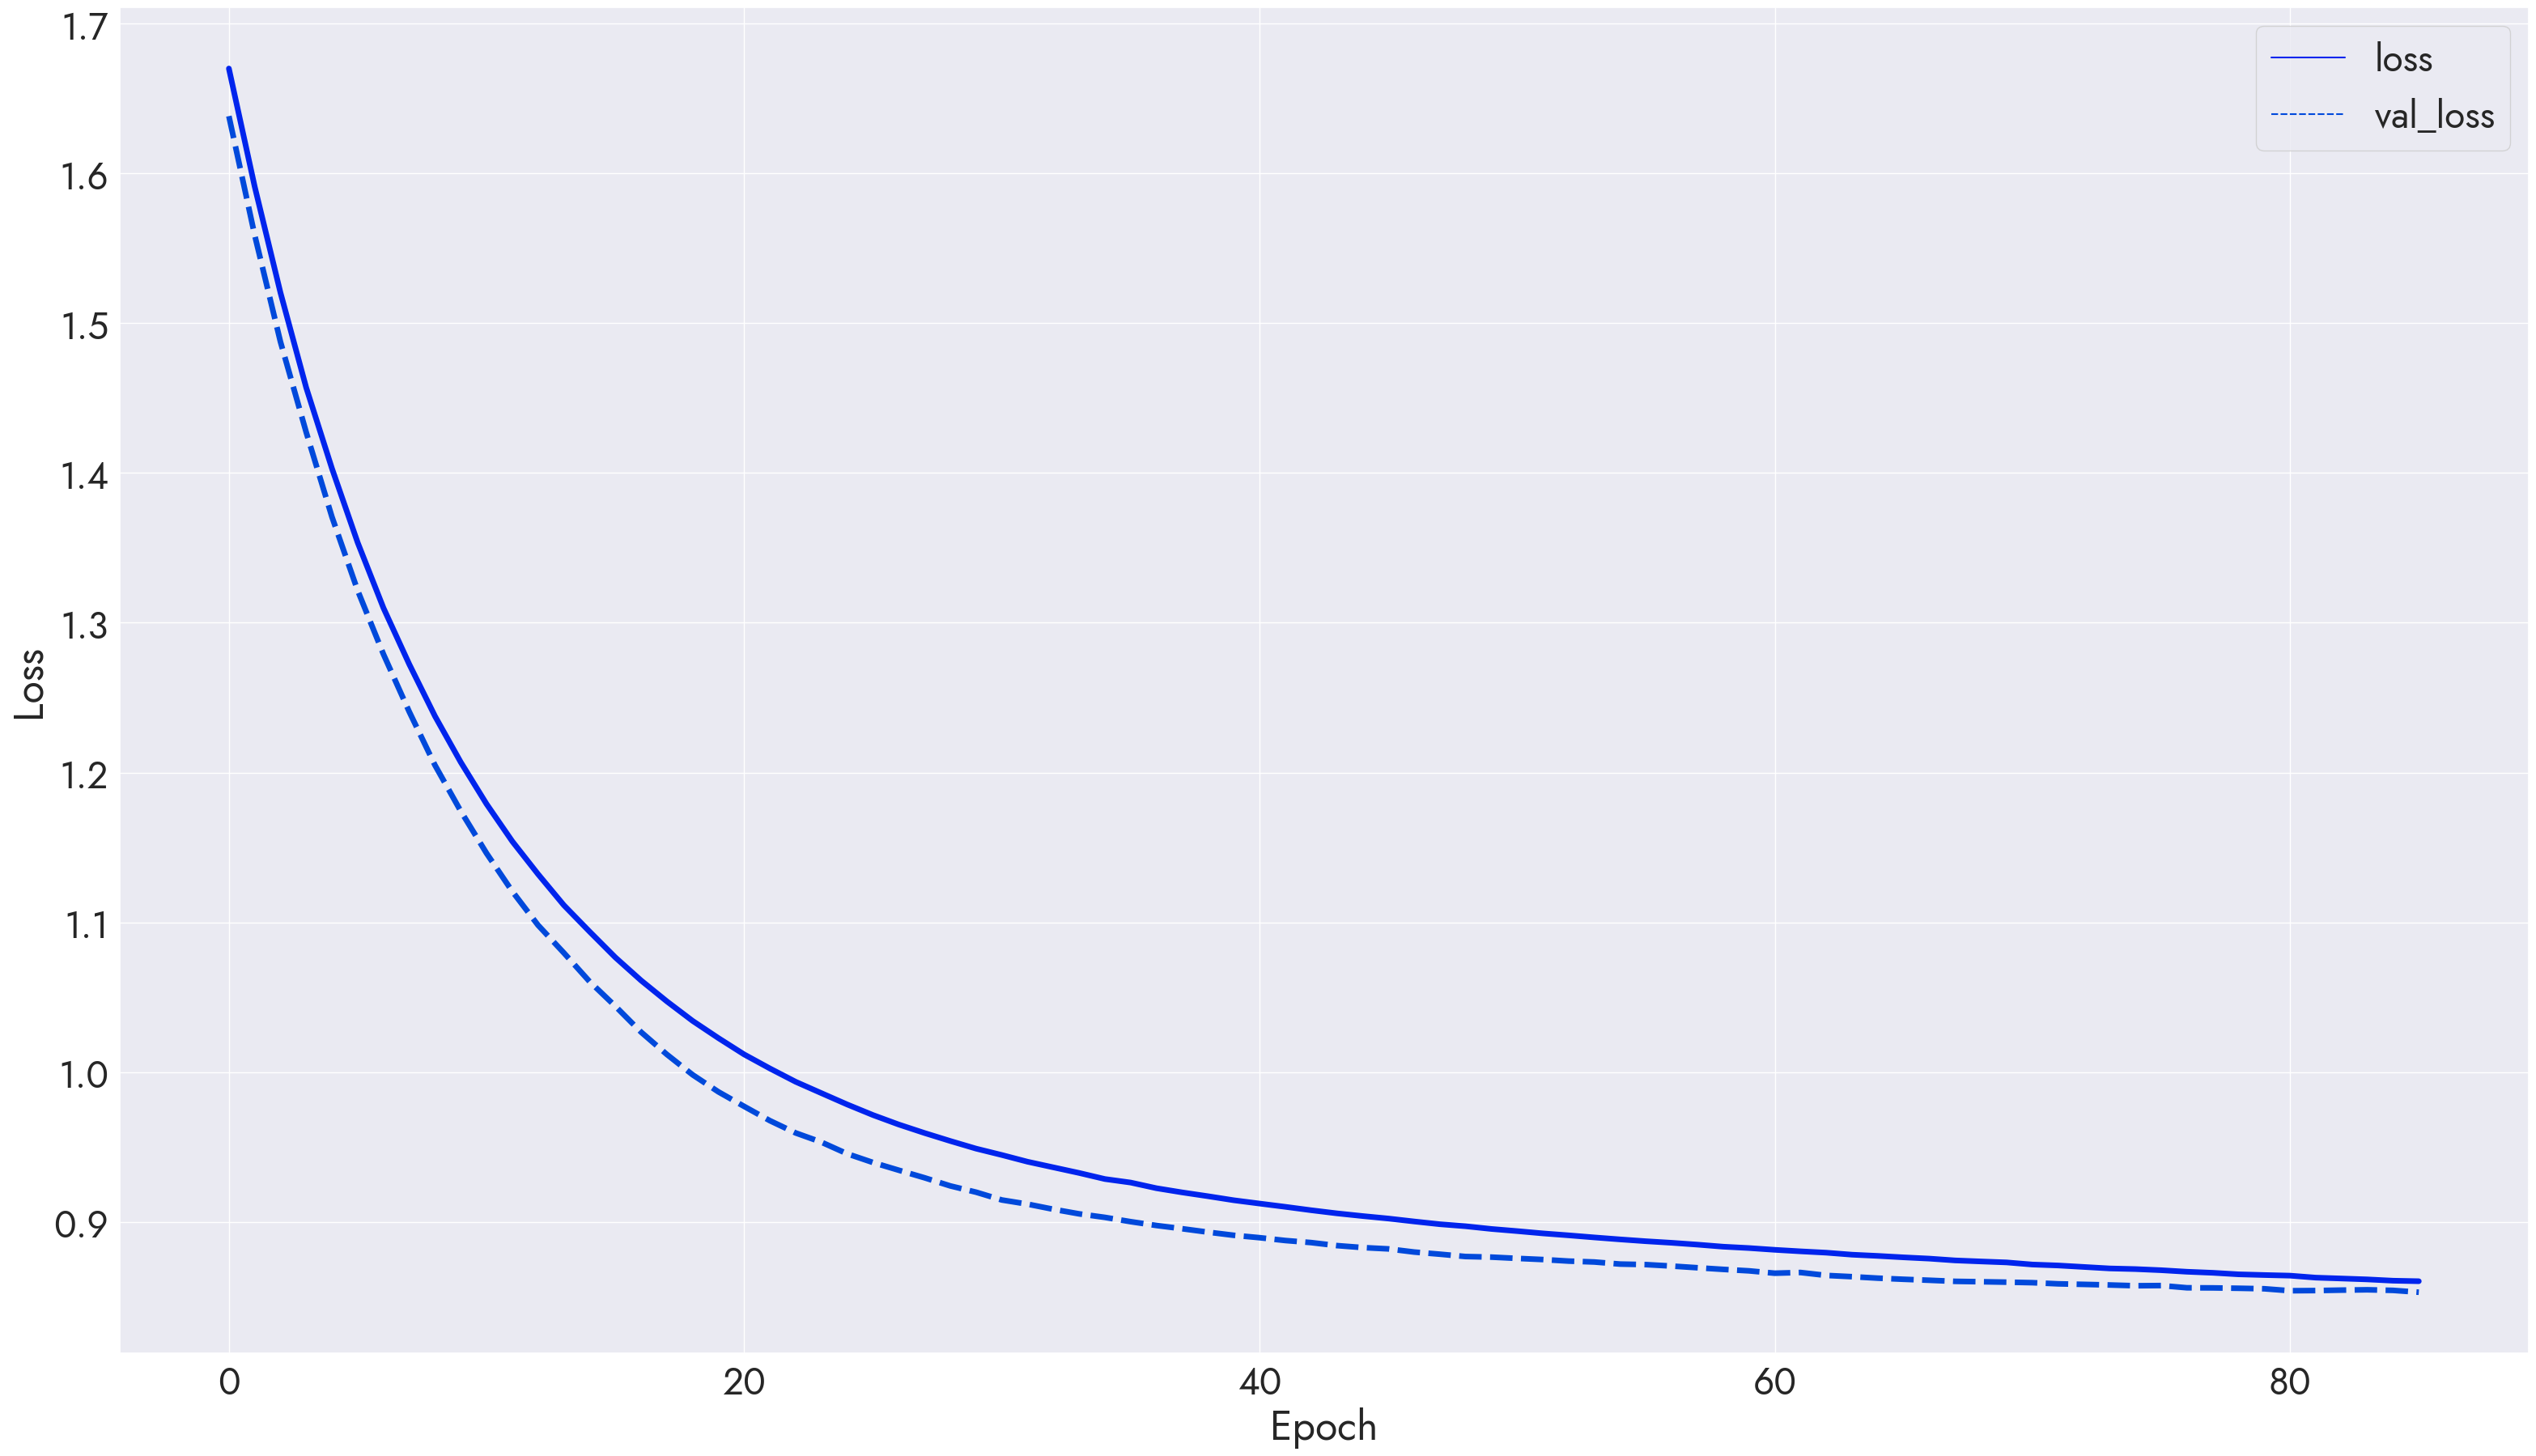

In [20]:
linear_plot_history = sns.lineplot(data=pd.DataFrame(linear_history)[['loss', 'val_loss']], linewidth=5)

linear_plot_history.set_xlabel('Epoch')
linear_plot_history.set_ylabel('Loss');

In [21]:
linear_plot_history.figure.savefig(f'{VISUAL_PATH}/fixed_linear_history.png', transparent=True)

Посмотрим предсказательные возможности модели

In [22]:
tiny_evaluation = linear_model.evaluate(train_features, train_target, batch_size=BATCH_SIZE, verbose=2)
print(f'Accuracy: {tiny_evaluation[1]}')

38/38 - 0s - loss: 0.8576 - accuracy: 0.6331 - 213ms/epoch - 6ms/step
Accuracy: 0.6330578327178955


In [23]:
small_evaluation = linear_model.evaluate(test_features, test_target, batch_size=BATCH_SIZE, verbose=2)
print(f'Accuracy: {small_evaluation[1]}')

10/10 - 0s - loss: 0.9606 - accuracy: 0.5695 - 70ms/epoch - 7ms/step
Accuracy: 0.5695364475250244


Как можно увидеть, объяснительные возможности модели сильно ограничены и она явно переобучена - точность предсказаний на тестовом наборе заметно ниже, чем на обучающем.
Сохраним модель для возможности её использования в будущем

In [24]:
linear_model.save(f'{MODEL_PATH}/fixed_small')

INFO:tensorflow:Assets written to: model/light/fixed_small/assets


### Модели глубокой нейронной сети (DNN)
Теперь перейдём к построению моделей, содержащих скрытые слои и имеющие нелинейную регрессию

Создадим переменную, в которой будут сохранятся логи обучения моделей

In [25]:
size_histories = {}

#### Tiny
Начнём с самой маленькой модели, состоящей из двух обучающих слоёв

In [26]:
tiny_model = tf.keras.Sequential(
    [
        normalize,
        tf.keras.layers.Dense(16, activation=tf.keras.activations.relu),
        tf.keras.layers.Dense(train_target.shape[1], activation=tf.keras.activations.softmax),
    ],
    name='tiny'
)

In [27]:
size_histories['tiny'] = compile_and_fit(tiny_model)

Model: "tiny"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization (Normalizatio  (None, 13)               27        
 n)                                                              
                                                                 
 dense_1 (Dense)             (None, 16)                224       
                                                                 
 dense_2 (Dense)             (None, 4)                 68        
                                                                 
Total params: 319
Trainable params: 292
Non-trainable params: 27
_________________________________________________________________
Epoch 1/100
31/31 - 1s - loss: 1.3550 - accuracy: 0.3864 - val_loss: 1.2948 - val_accuracy: 0.4132 - 1s/epoch - 38ms/step
Epoch 2/100
31/31 - 0s - loss: 1.2472 - accuracy: 0.4421 - val_loss: 1.1924 - val_accuracy: 0.4545 - 241ms/epoch - 8ms/step
Epoch 3/100
31/

Визуализируем ход обучения

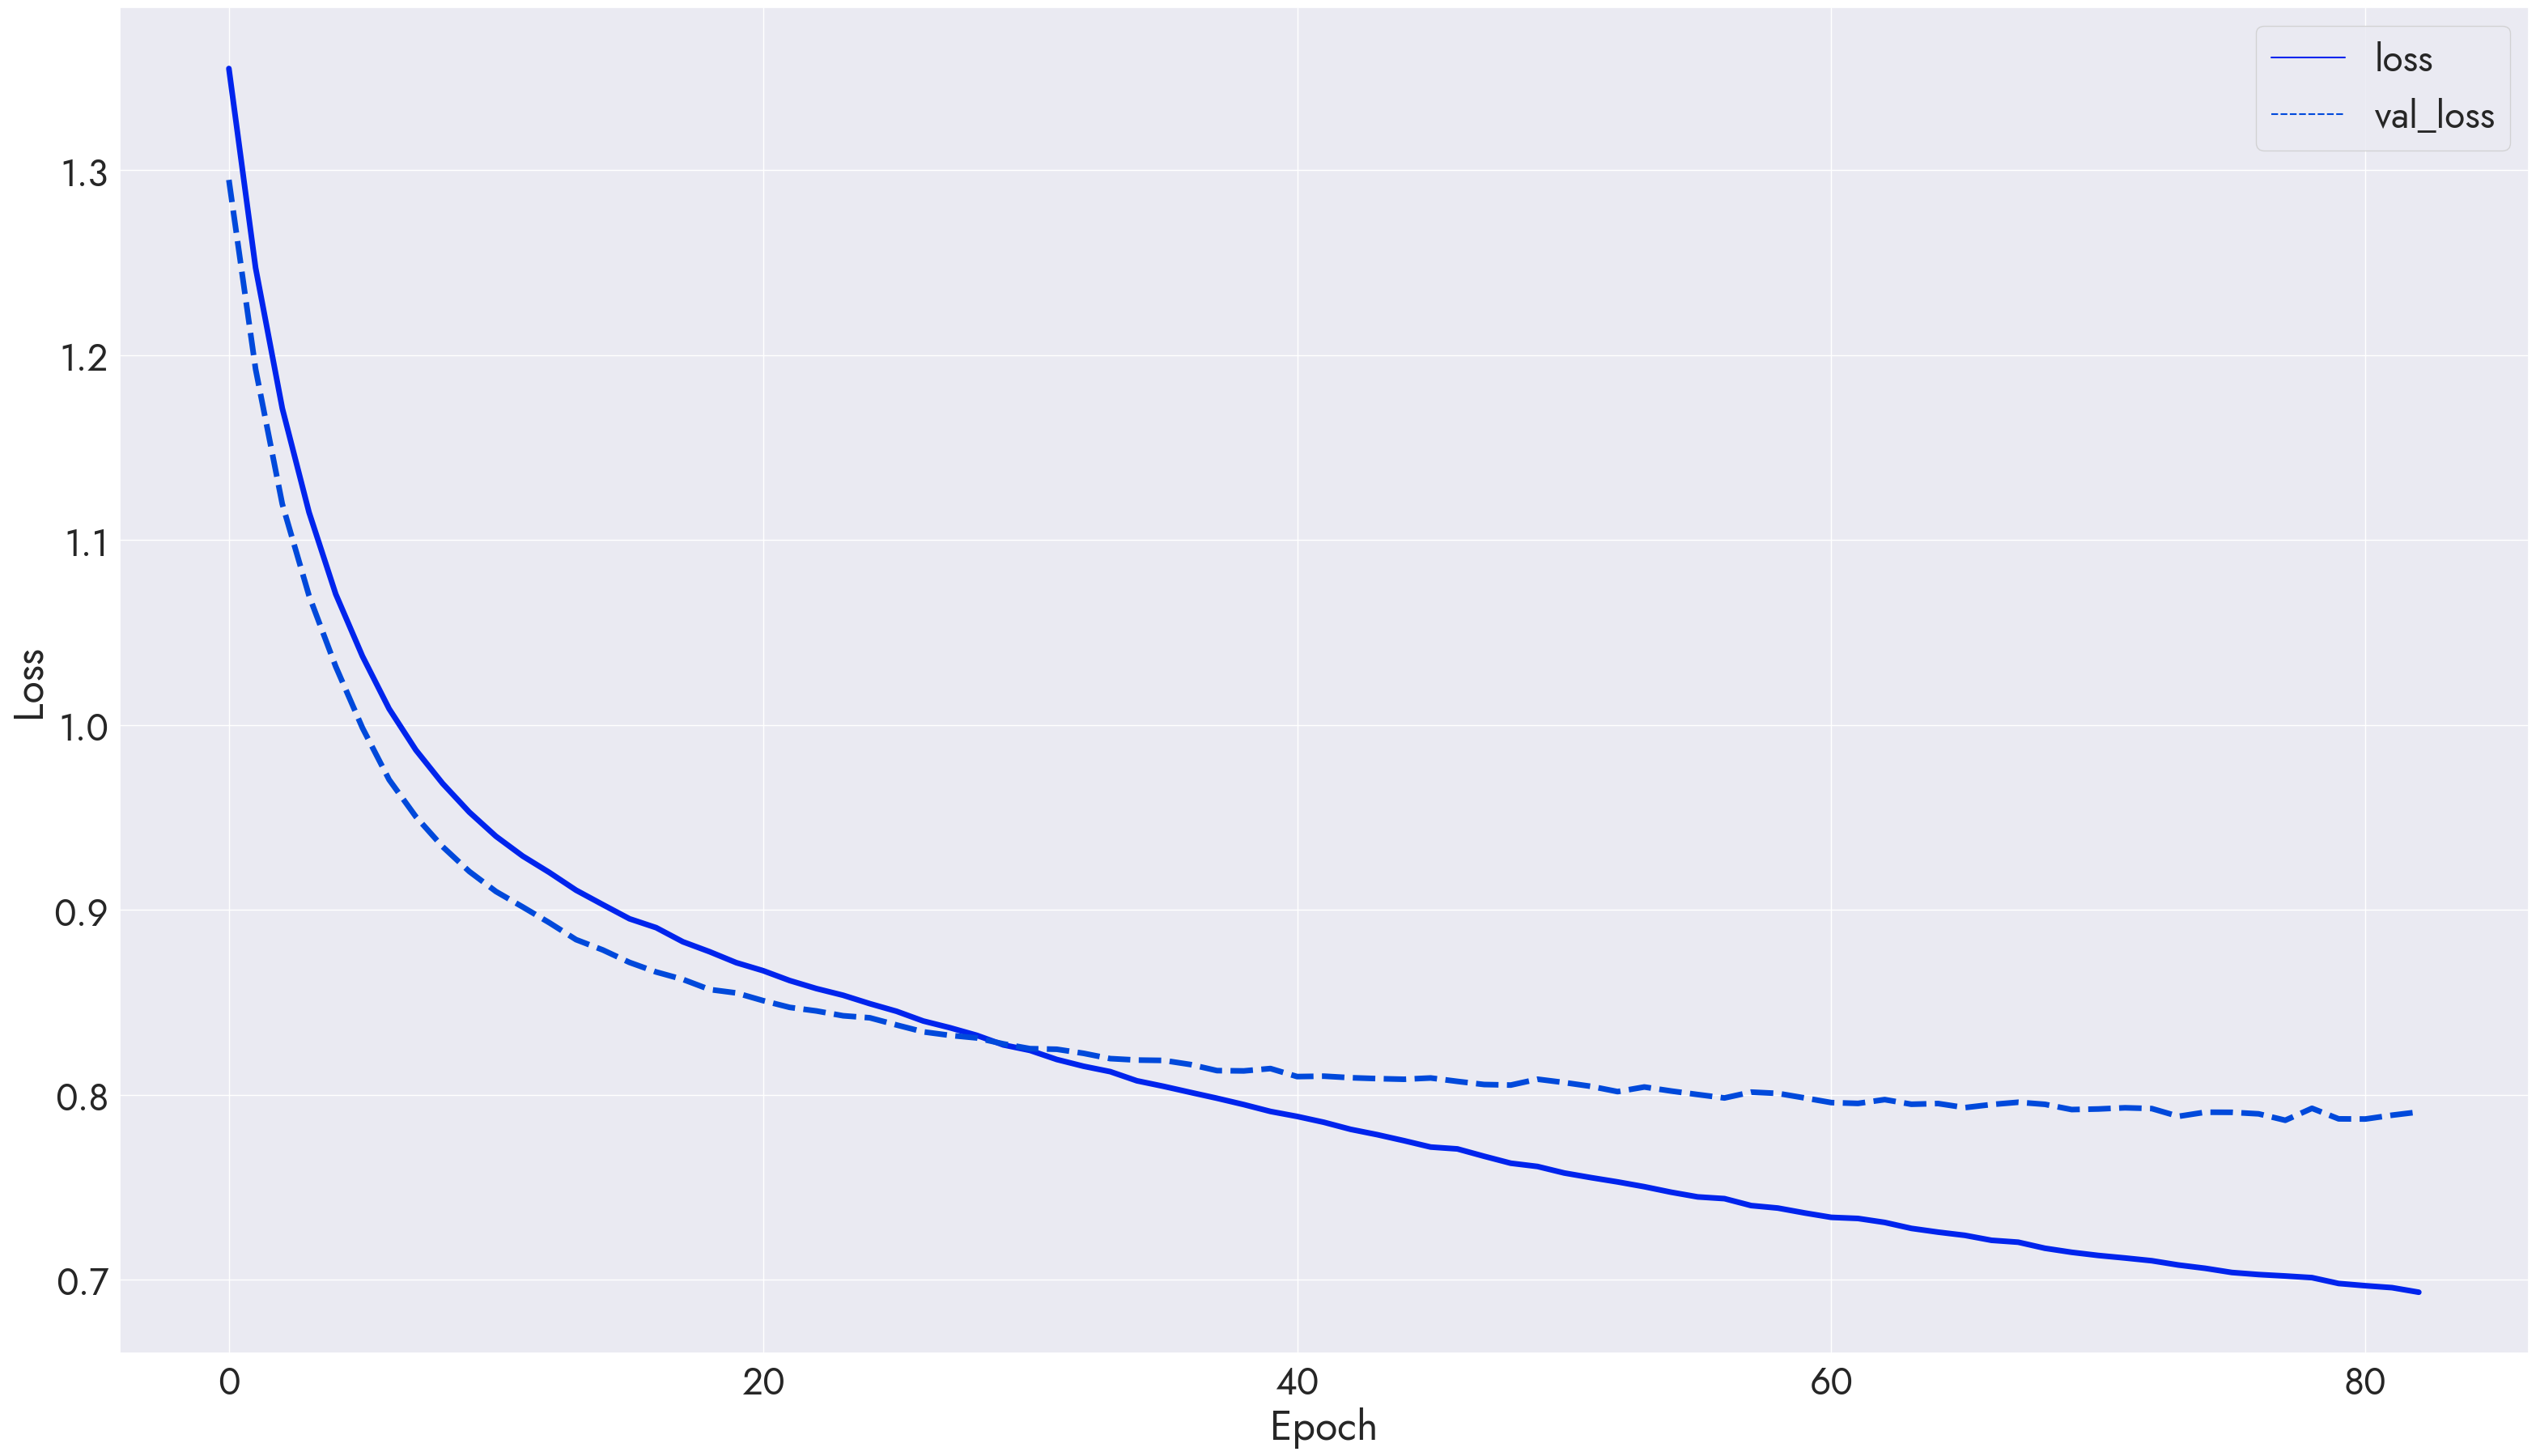

In [28]:
tiny_plot_history = sns.lineplot(data=pd.DataFrame(size_histories['tiny'])[['loss', 'val_loss']], linewidth=5)

tiny_plot_history.set_xlabel('Epoch')
tiny_plot_history.set_ylabel('Loss');

In [29]:
tiny_plot_history.figure.savefig(f'{VISUAL_PATH}/fixed_tiny_history.png', transparent=True)

Посмотрим предсказательные возможности модели

In [30]:
tiny_evaluation = tiny_model.evaluate(train_features, train_target, batch_size=BATCH_SIZE, verbose=2)
print(f'Accuracy: {tiny_evaluation[1]}')

38/38 - 0s - loss: 0.7098 - accuracy: 0.7107 - 214ms/epoch - 6ms/step
Accuracy: 0.71074378490448


In [31]:
tiny_evaluation = tiny_model.evaluate(test_features, test_target, batch_size=BATCH_SIZE, verbose=2)
print(f'Accuracy: {tiny_evaluation[1]}')

10/10 - 0s - loss: 0.8322 - accuracy: 0.6093 - 79ms/epoch - 8ms/step
Accuracy: 0.6092715263366699


Сохраним модель для возможности её использования в будущем

In [32]:
tiny_model.save(f'{MODEL_PATH}/fixed_tiny')

INFO:tensorflow:Assets written to: model/light/fixed_tiny/assets


#### Small

In [33]:
small_model = tf.keras.Sequential(
    [
        normalize,
        tf.keras.layers.Dense(16, activation=tf.keras.activations.relu),
        tf.keras.layers.Dense(16, activation=tf.keras.activations.relu),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Dense(train_target.shape[1], activation=tf.keras.activations.softmax),
    ],
    name='small'
)

In [34]:
size_histories['small'] = compile_and_fit(small_model)

Model: "small"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization (Normalizatio  (None, 13)               27        
 n)                                                              
                                                                 
 dense_3 (Dense)             (None, 16)                224       
                                                                 
 dense_4 (Dense)             (None, 16)                272       
                                                                 
 dropout (Dropout)           (None, 16)                0         
                                                                 
 dense_5 (Dense)             (None, 4)                 68        
                                                                 
Total params: 591
Trainable params: 564
Non-trainable params: 27
______________________________________________________________

Визуализируем ход обучения

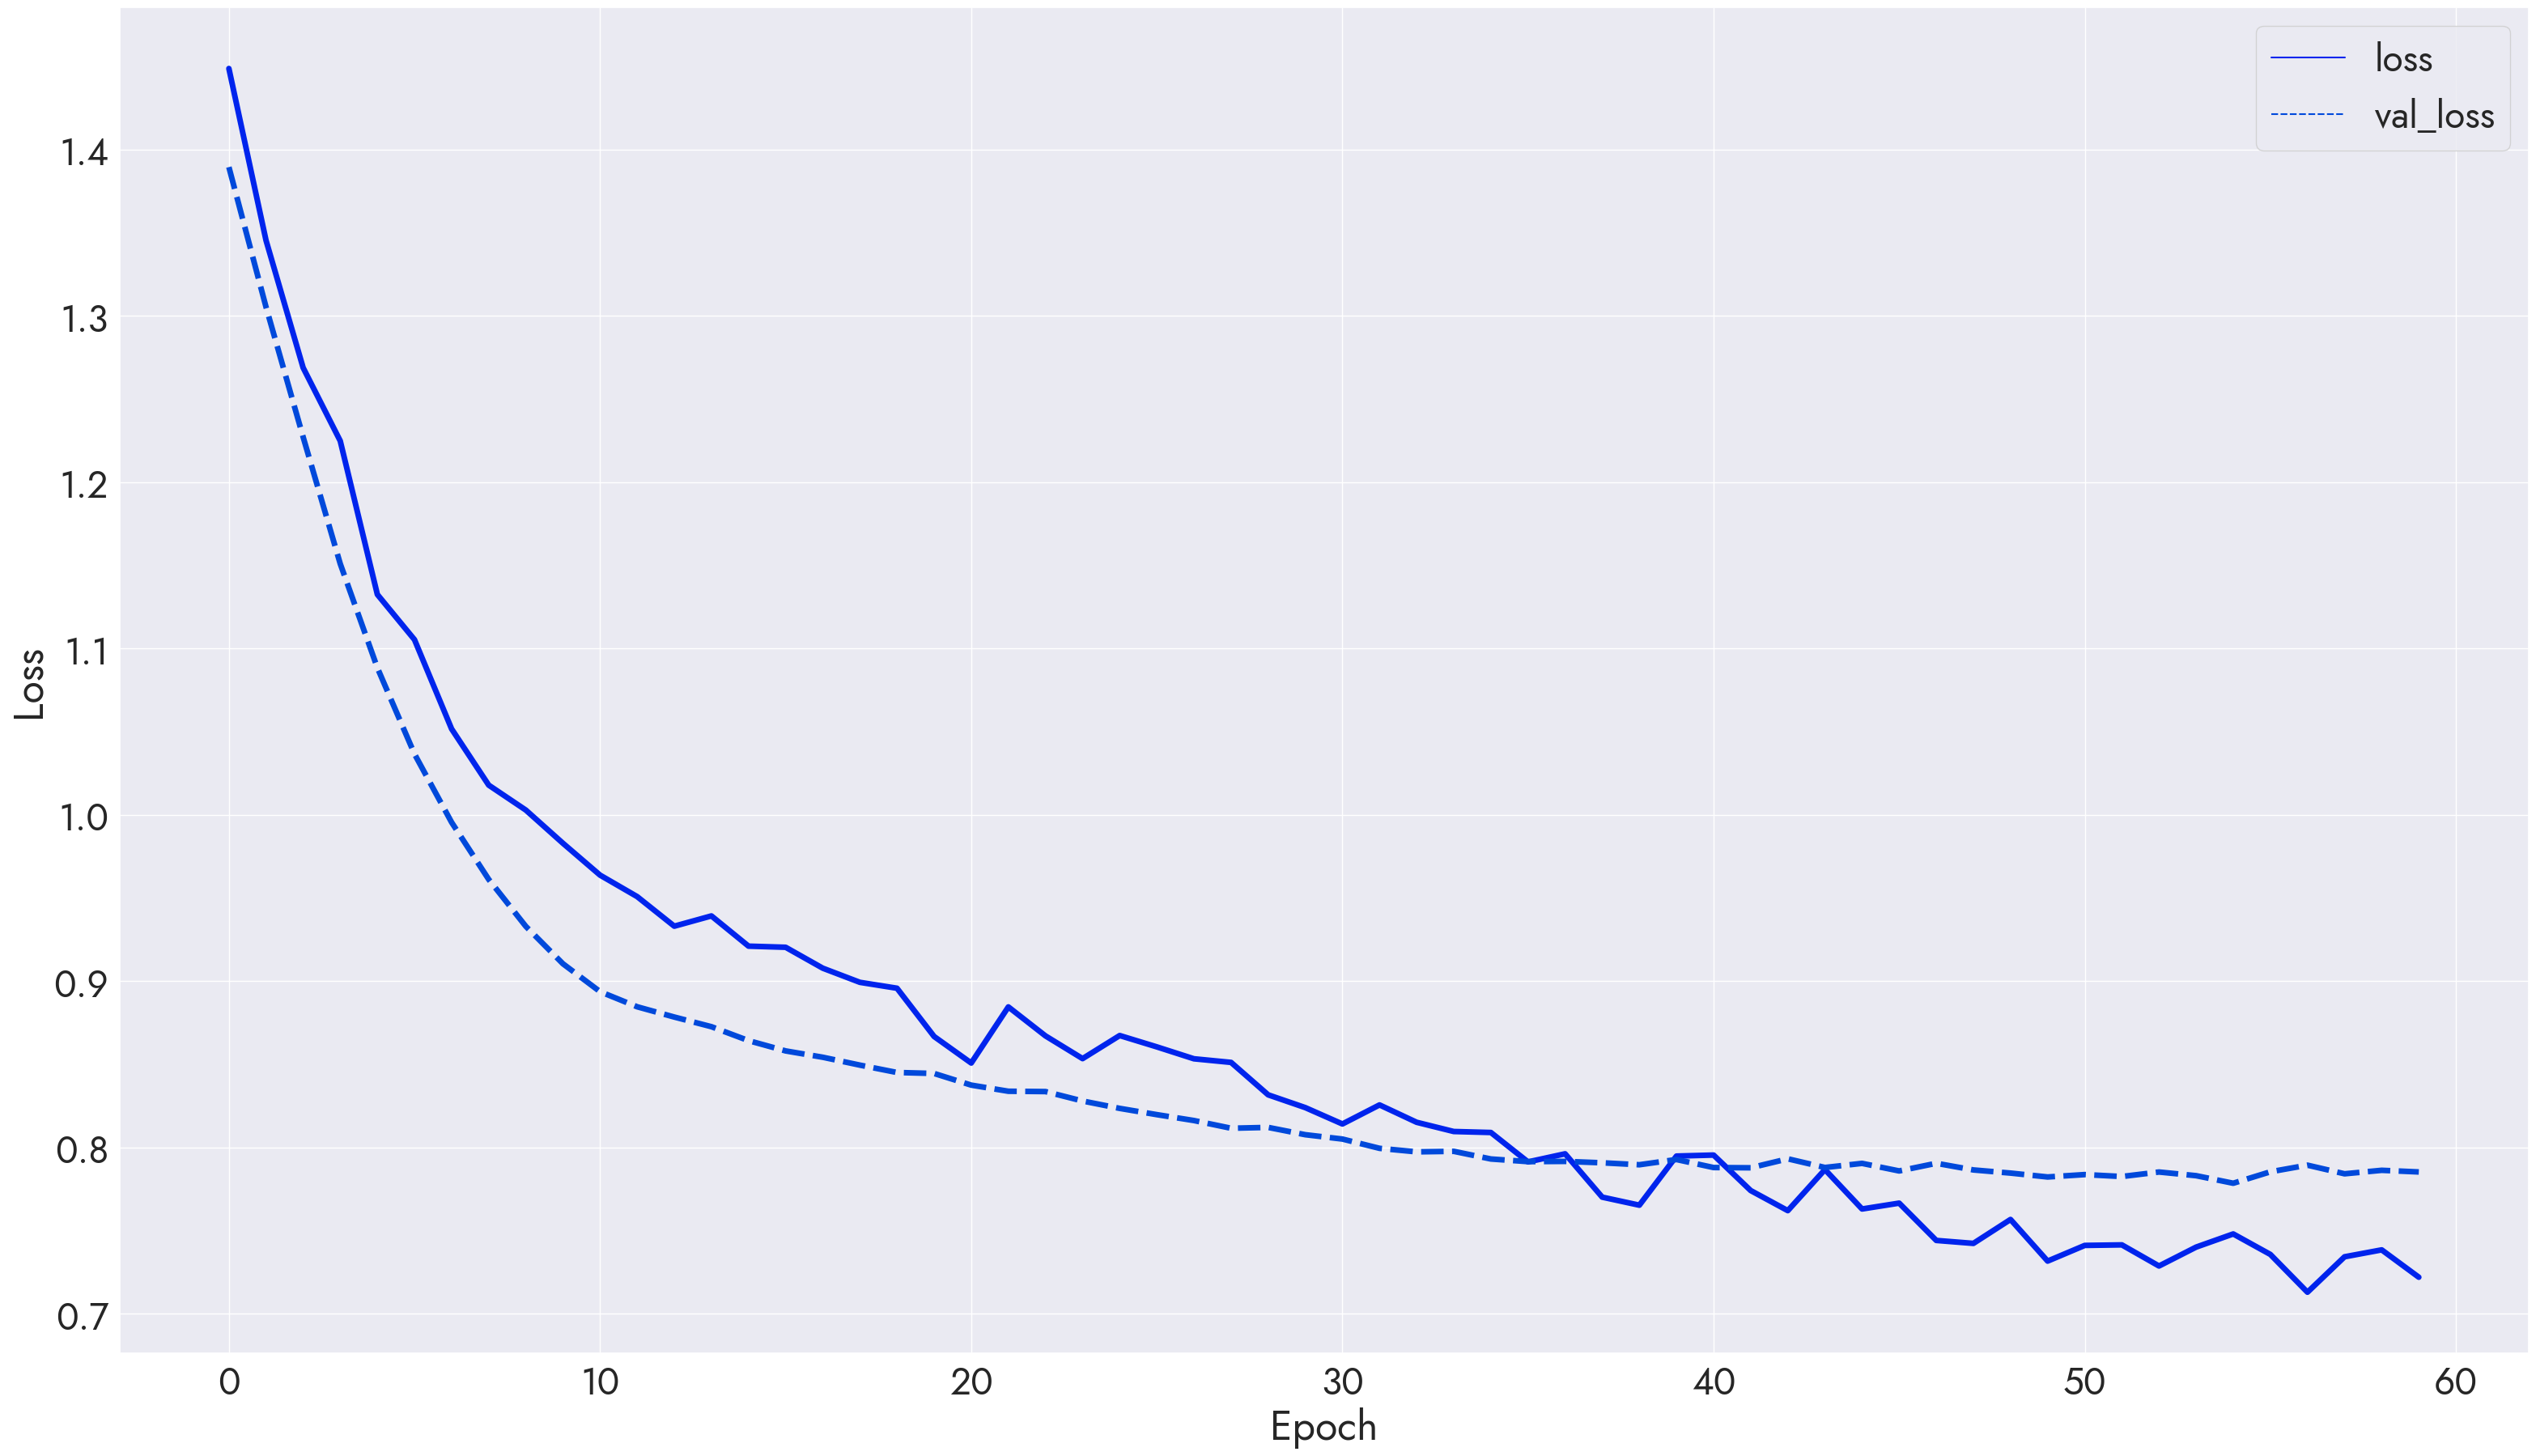

In [35]:
small_plot_history = sns.lineplot(data=pd.DataFrame(size_histories['small'])[['loss', 'val_loss']], linewidth=5)

small_plot_history.set_xlabel('Epoch')
small_plot_history.set_ylabel('Loss');

In [36]:
small_plot_history.figure.savefig(f'{VISUAL_PATH}/fixed_small_history.png', transparent=True)

Посмотрим предсказательные возможности модели

In [37]:
small_evaluation = small_model.evaluate(train_features, train_target, batch_size=BATCH_SIZE, verbose=2)
print(f'Accuracy: {small_evaluation[1]}')

38/38 - 0s - loss: 0.6957 - accuracy: 0.7289 - 195ms/epoch - 5ms/step
Accuracy: 0.7289256453514099


In [38]:
small_evaluation = small_model.evaluate(test_features, test_target, batch_size=BATCH_SIZE, verbose=2)
print(f'Accuracy: {small_evaluation[1]}')

10/10 - 0s - loss: 0.8182 - accuracy: 0.6225 - 67ms/epoch - 7ms/step
Accuracy: 0.6225165724754333


Сохраним модель для возможности её использования в будущем

In [39]:
small_model.save(f'{MODEL_PATH}/fixed_small')

2023-05-13 21:14:15.859733: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,16]
	 [[{{node inputs}}]]
2023-05-13 21:14:16.187779: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,16]
	 [[{{node inputs}}]]


INFO:tensorflow:Assets written to: model/light/fixed_small/assets


#### Medium

In [40]:
medium_model = tf.keras.Sequential(
    [
        normalize,
        tf.keras.layers.Dense(64, kernel_regularizer=tf.keras.regularizers.l2(), activation=tf.keras.activations.relu),
        tf.keras.layers.Dense(64, activation=tf.keras.activations.relu),
        tf.keras.layers.Dropout(0.3),
        tf.keras.layers.Dense(train_target.shape[1], activation=tf.keras.activations.softmax),
    ],
    name='medium'
)

In [41]:
size_histories['medium'] = compile_and_fit(medium_model)

Model: "medium"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization (Normalizatio  (None, 13)               27        
 n)                                                              
                                                                 
 dense_6 (Dense)             (None, 64)                896       
                                                                 
 dense_7 (Dense)             (None, 64)                4160      
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                                 
 dense_8 (Dense)             (None, 4)                 260       
                                                                 
Total params: 5,343
Trainable params: 5,316
Non-trainable params: 27
_________________________________________________________

Визуализируем ход обучения

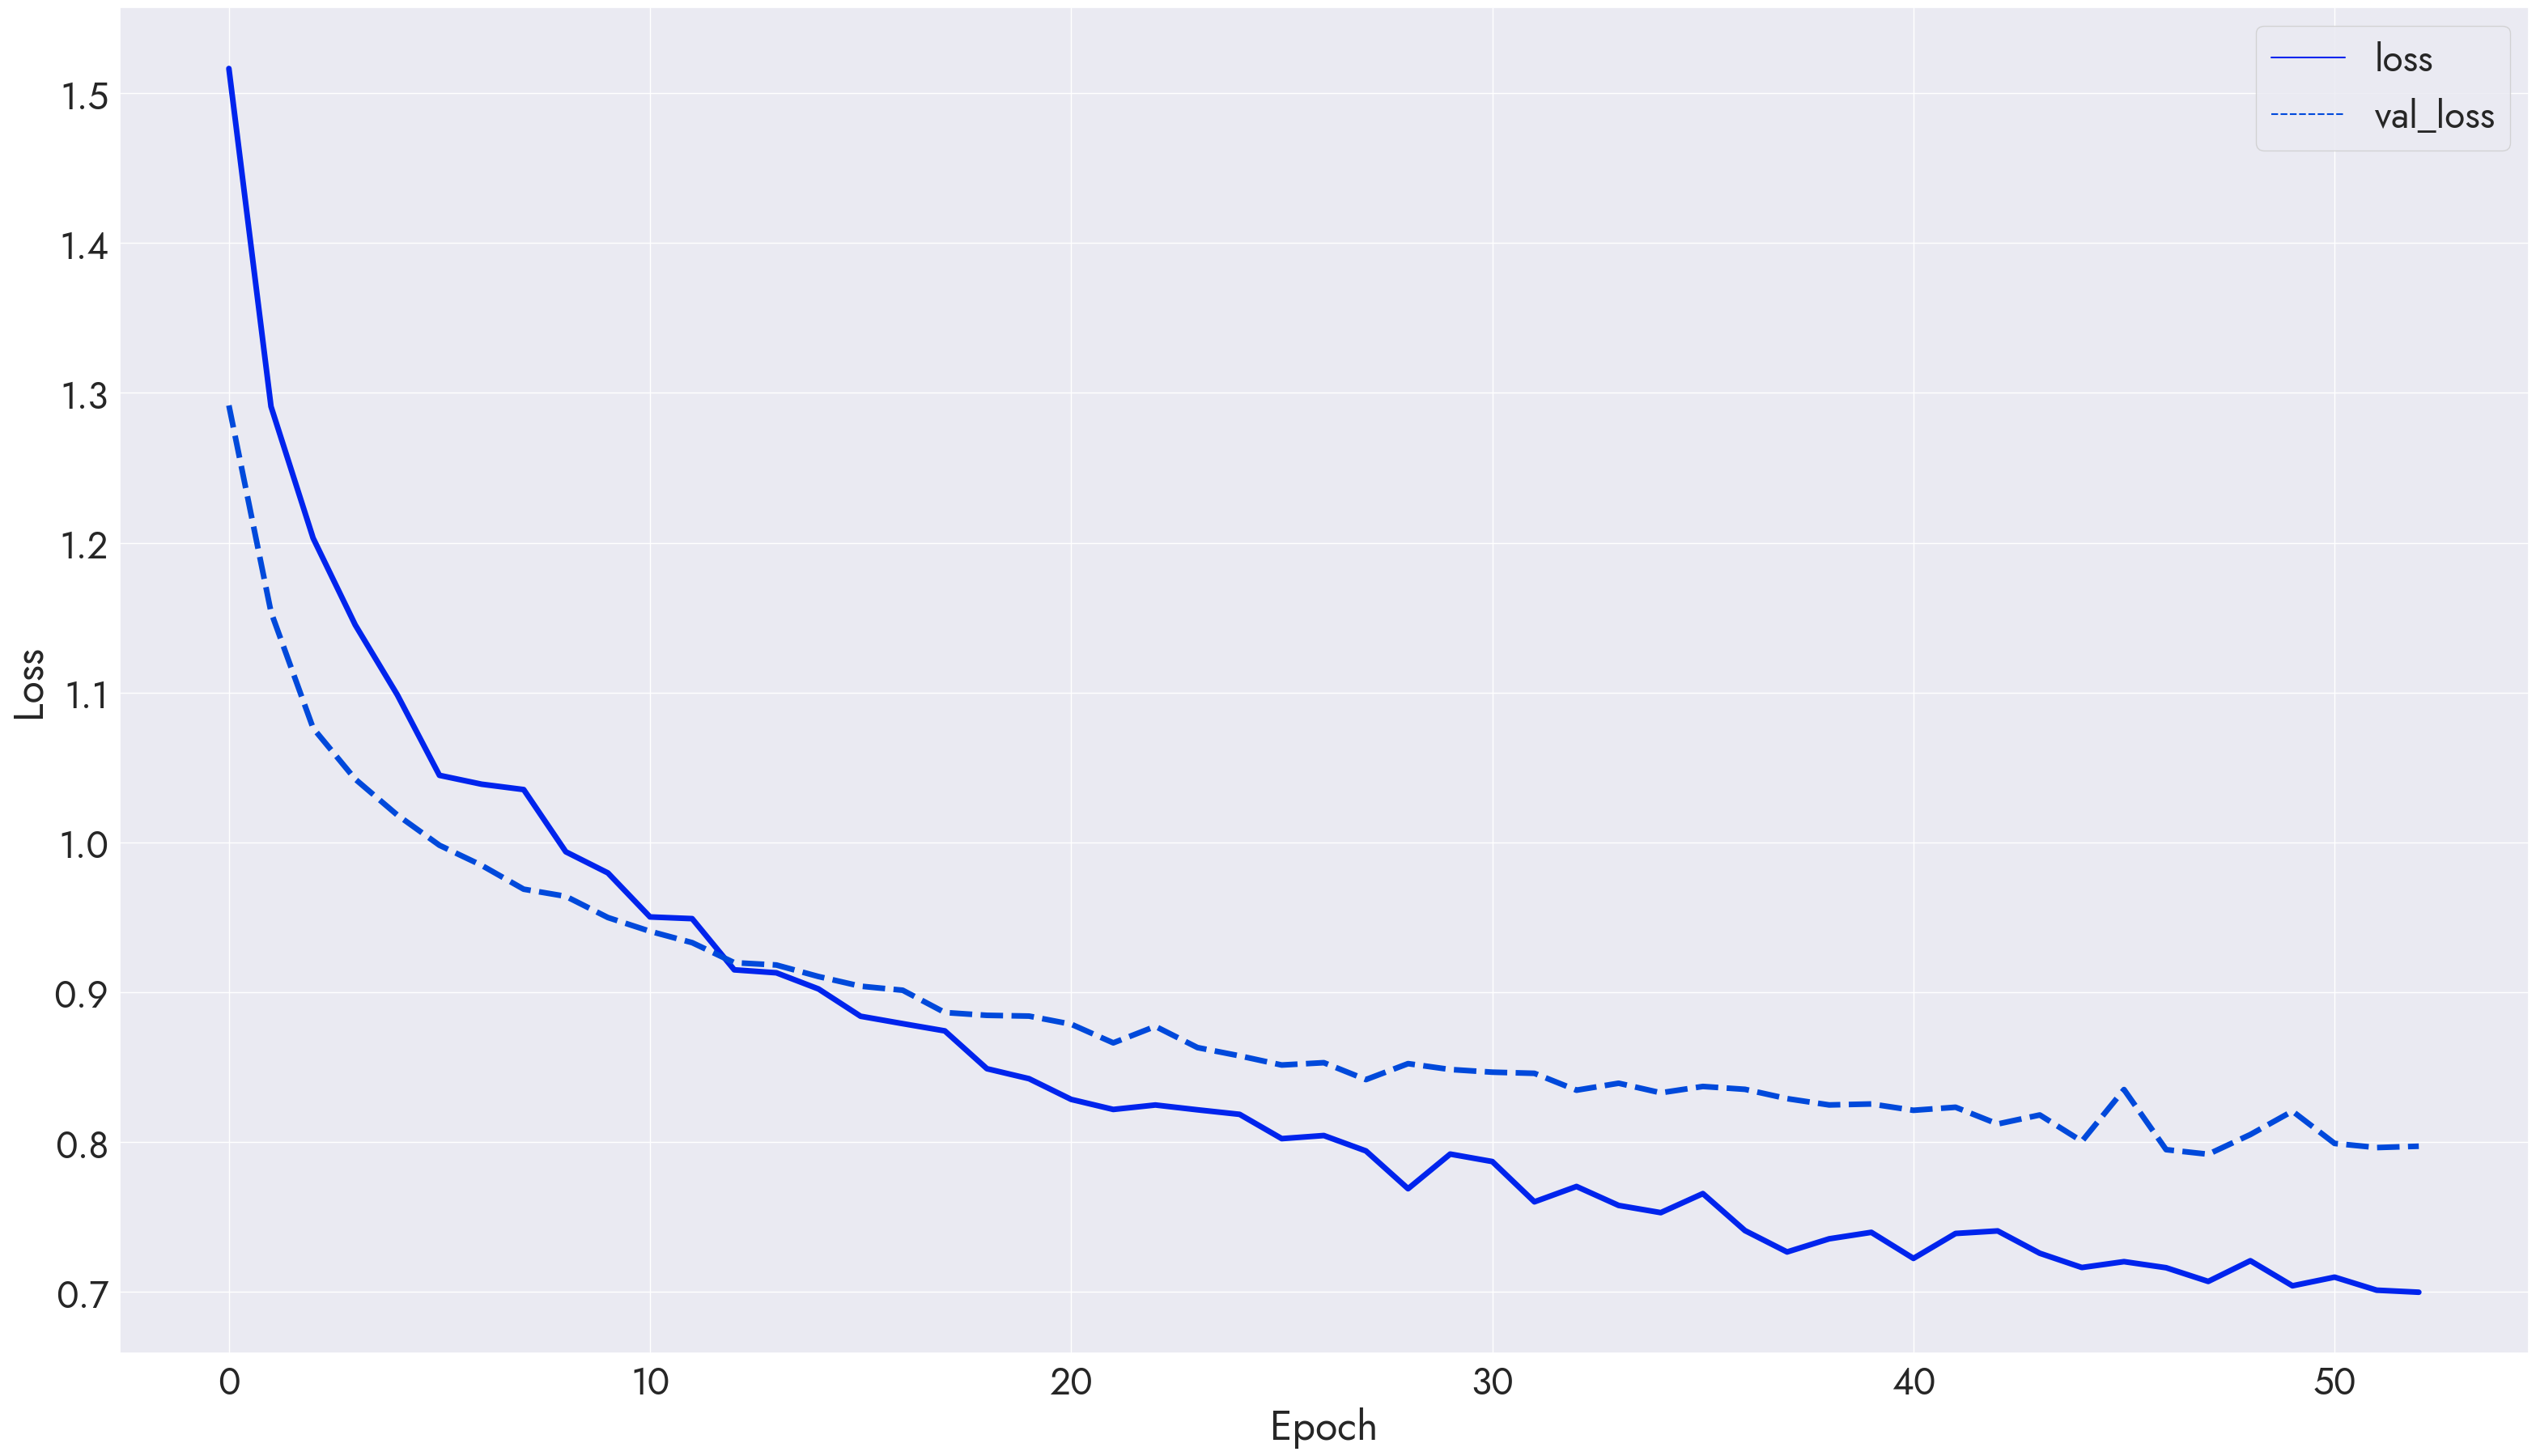

In [42]:
medium_plot_history = sns.lineplot(data=pd.DataFrame(size_histories['medium'])[['loss', 'val_loss']], linewidth=5)

medium_plot_history.set_xlabel('Epoch')
medium_plot_history.set_ylabel('Loss');

In [43]:
medium_plot_history.figure.savefig(f'{VISUAL_PATH}/fixed_medium_history.png', transparent=True)

Посмотрим предсказательные возможности модели

In [44]:
medium_evaluation = medium_model.evaluate(train_features, train_target, batch_size=BATCH_SIZE, verbose=2)
print(f'Accuracy: {medium_evaluation[1]}')

38/38 - 0s - loss: 0.6879 - accuracy: 0.7372 - 196ms/epoch - 5ms/step
Accuracy: 0.7371900677680969


In [45]:
medium_evaluation = medium_model.evaluate(test_features, test_target, batch_size=BATCH_SIZE, verbose=2)
print(f'Accuracy: {medium_evaluation[1]}')

10/10 - 0s - loss: 0.8377 - accuracy: 0.6490 - 69ms/epoch - 7ms/step
Accuracy: 0.6490066051483154


Сохраним модель для возможности её использования в будущем

In [46]:
medium_model.save(f'{MODEL_PATH}/fixed_medium')

2023-05-13 21:14:32.421170: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,64]
	 [[{{node inputs}}]]
2023-05-13 21:14:32.582916: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,64]
	 [[{{node inputs}}]]


INFO:tensorflow:Assets written to: model/light/fixed_medium/assets


#### Large

In [47]:
large_model = tf.keras.Sequential(
    [
        normalize,
        tf.keras.layers.Dense(512, kernel_regularizer=tf.keras.regularizers.l2(), activation=tf.keras.activations.relu),
        tf.keras.layers.Dense(512, kernel_regularizer=tf.keras.regularizers.l2(), activation=tf.keras.activations.relu),
        tf.keras.layers.Dropout(0.3),
        tf.keras.layers.Dense(64, activation=tf.keras.activations.relu),
        tf.keras.layers.Dense(64, activation=tf.keras.activations.relu),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Dense(train_target.shape[1], activation=tf.keras.activations.softmax),
    ],
    name='large'
)

In [48]:
size_histories['large'] = compile_and_fit(large_model)

Model: "large"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization (Normalizatio  (None, 13)               27        
 n)                                                              
                                                                 
 dense_9 (Dense)             (None, 512)               7168      
                                                                 
 dense_10 (Dense)            (None, 512)               262656    
                                                                 
 dropout_2 (Dropout)         (None, 512)               0         
                                                                 
 dense_11 (Dense)            (None, 64)                32832     
                                                                 
 dense_12 (Dense)            (None, 64)                4160      
                                                             

Визуализируем ход обучения

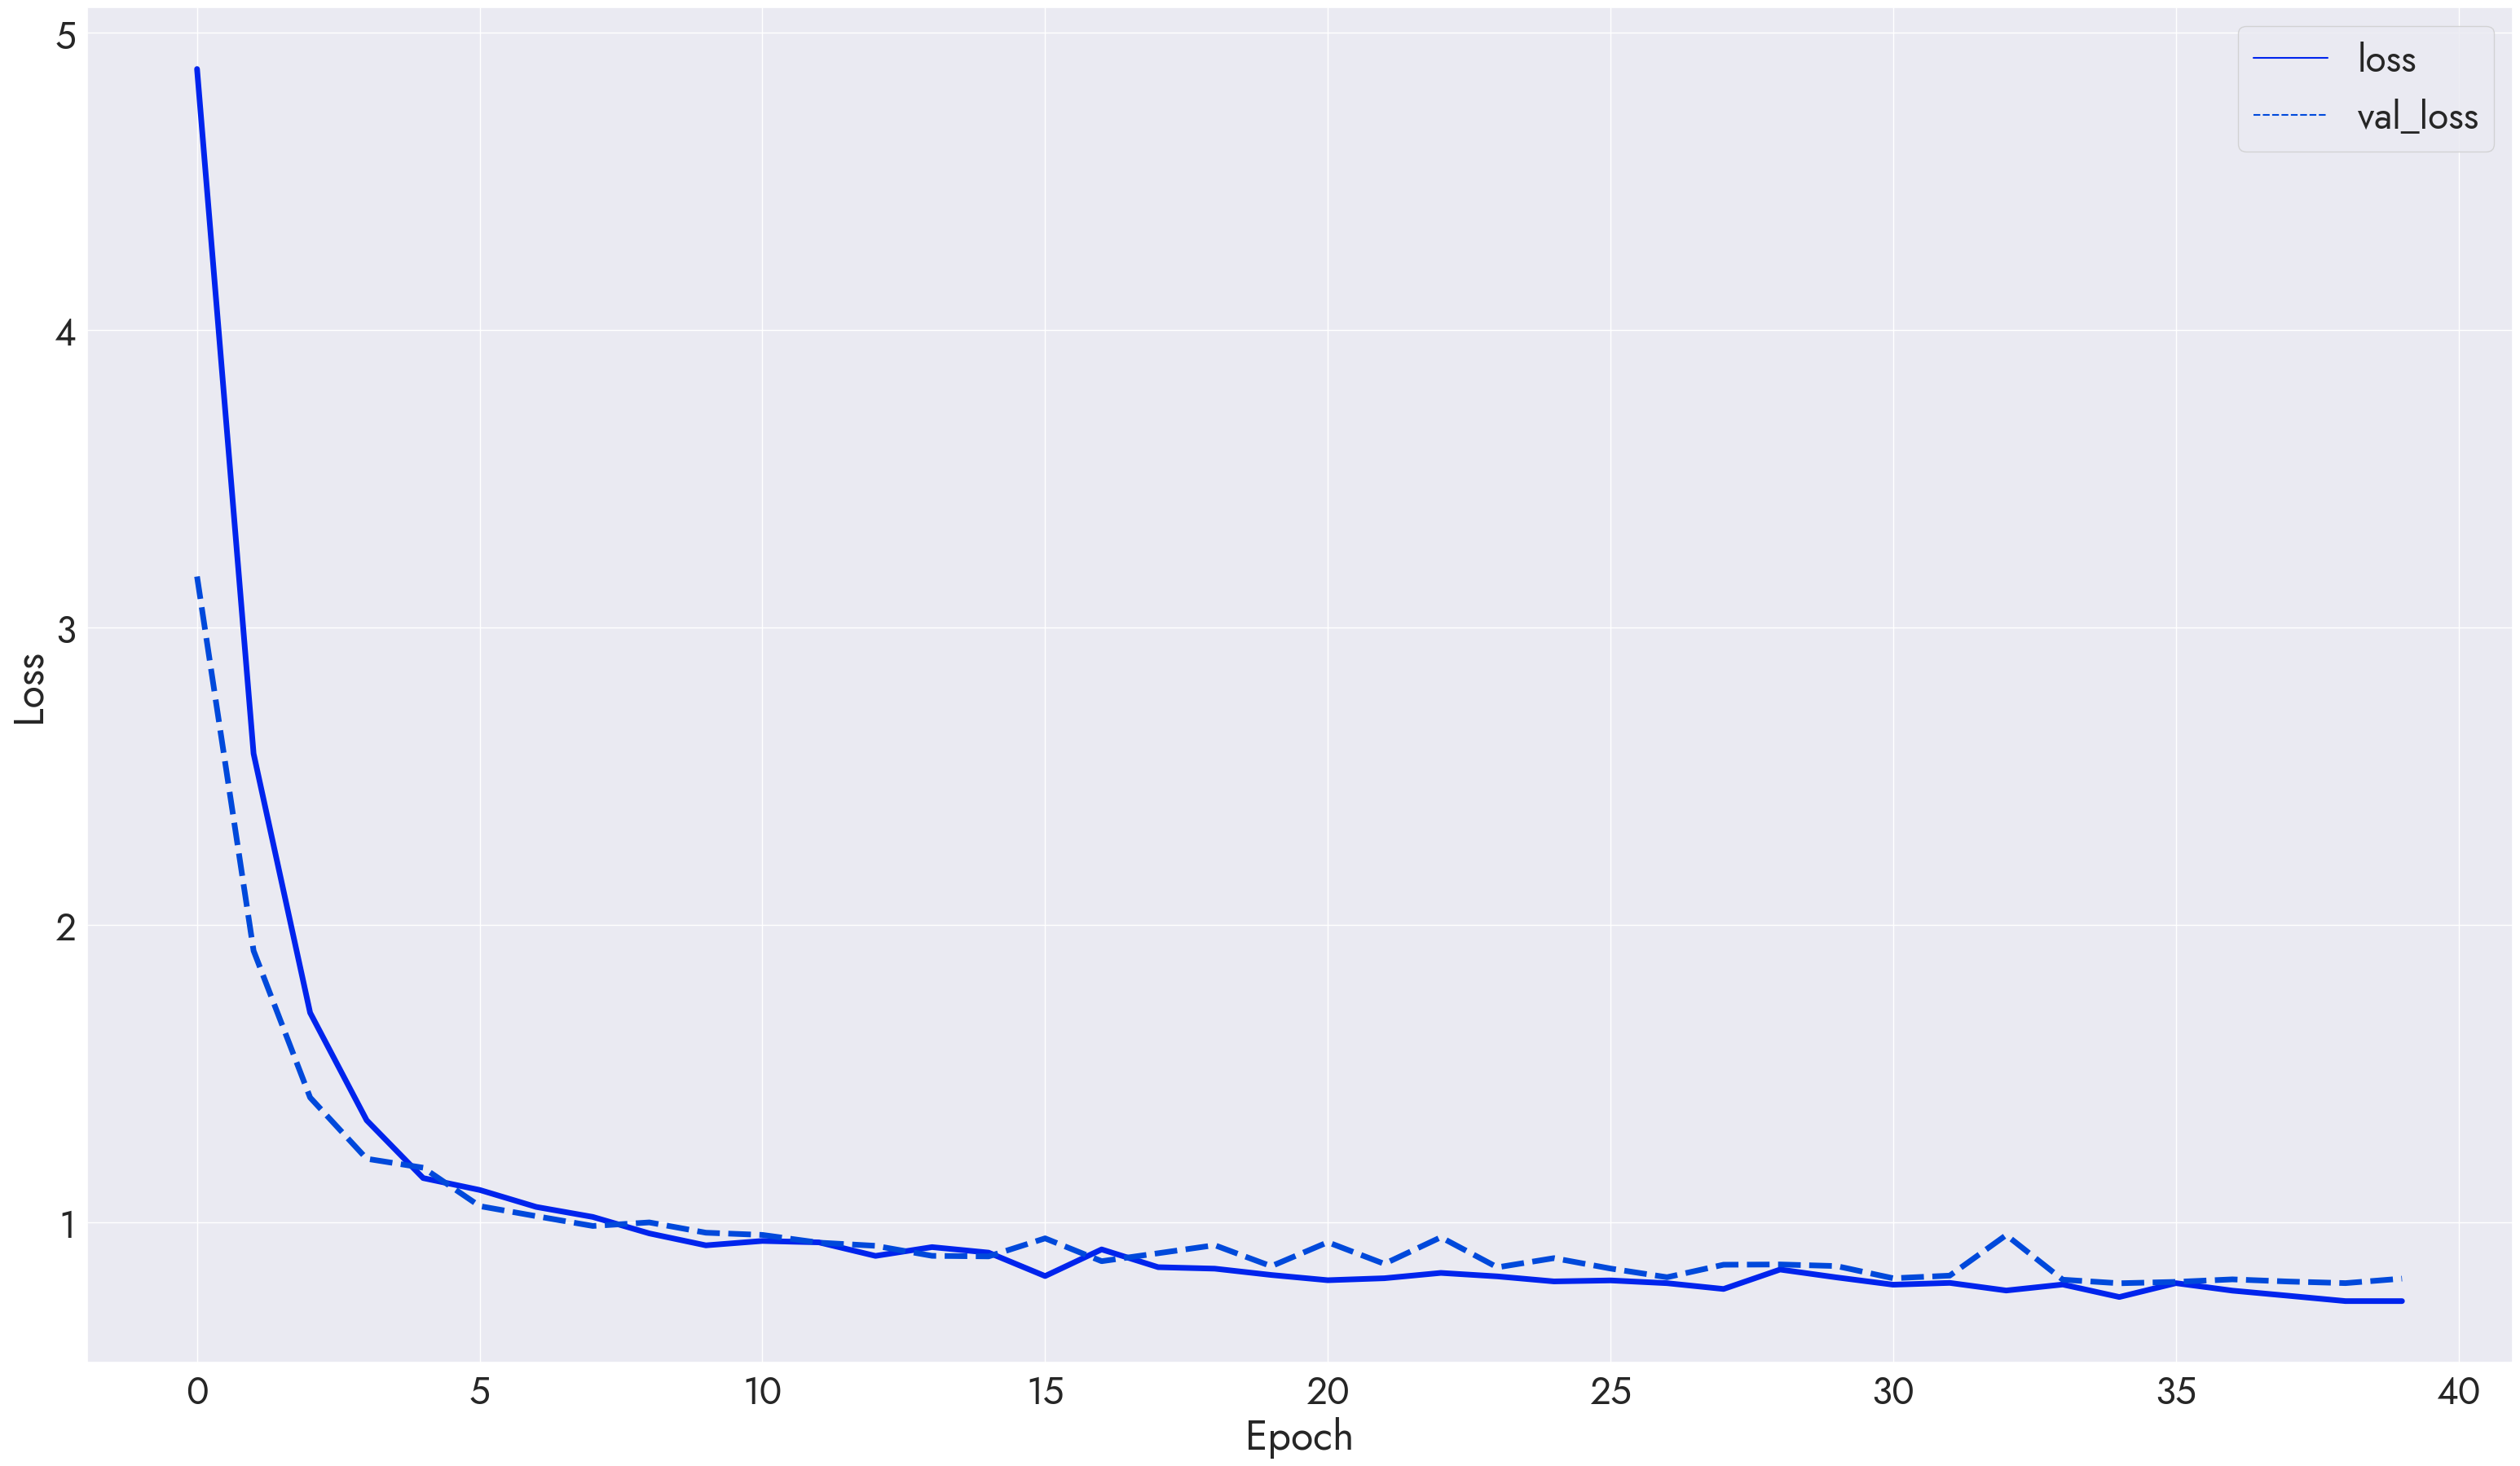

In [49]:
large_plot_history = sns.lineplot(data=pd.DataFrame(size_histories['large'])[['loss', 'val_loss']], linewidth=5)

large_plot_history.set_xlabel('Epoch')
large_plot_history.set_ylabel('Loss');

In [50]:
large_plot_history.figure.savefig(f'{VISUAL_PATH}/fixed_large_history.png', transparent=True)

Посмотрим предсказательные возможности модели

In [51]:
large_evaluation = large_model.evaluate(train_features, train_target, batch_size=BATCH_SIZE, verbose=2)
print(f'Accuracy: {large_evaluation[1]}')

38/38 - 0s - loss: 0.7434 - accuracy: 0.7388 - 179ms/epoch - 5ms/step
Accuracy: 0.7388429641723633


In [52]:
large_evaluation = large_model.evaluate(test_features, test_target, batch_size=BATCH_SIZE, verbose=2)
print(f'Accuracy: {large_evaluation[1]}')

10/10 - 0s - loss: 0.9267 - accuracy: 0.6225 - 71ms/epoch - 7ms/step
Accuracy: 0.6225165724754333


Сохраним модель для возможности её использования в будущем

In [53]:
large_model.save(f'{MODEL_PATH}/fixed_large')

2023-05-13 21:14:47.304578: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,512]
	 [[{{node inputs}}]]
2023-05-13 21:14:47.321901: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,64]
	 [[{{node inputs}}]]
2023-05-13 21:14:47.536500: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,512]
	 [[{{node inputs}}]]
2023-05-13 21:14:

INFO:tensorflow:Assets written to: model/light/fixed_large/assets


#### Итоговая модель
Визуализируем процесс расчёта точности предсказаний для каждой модели

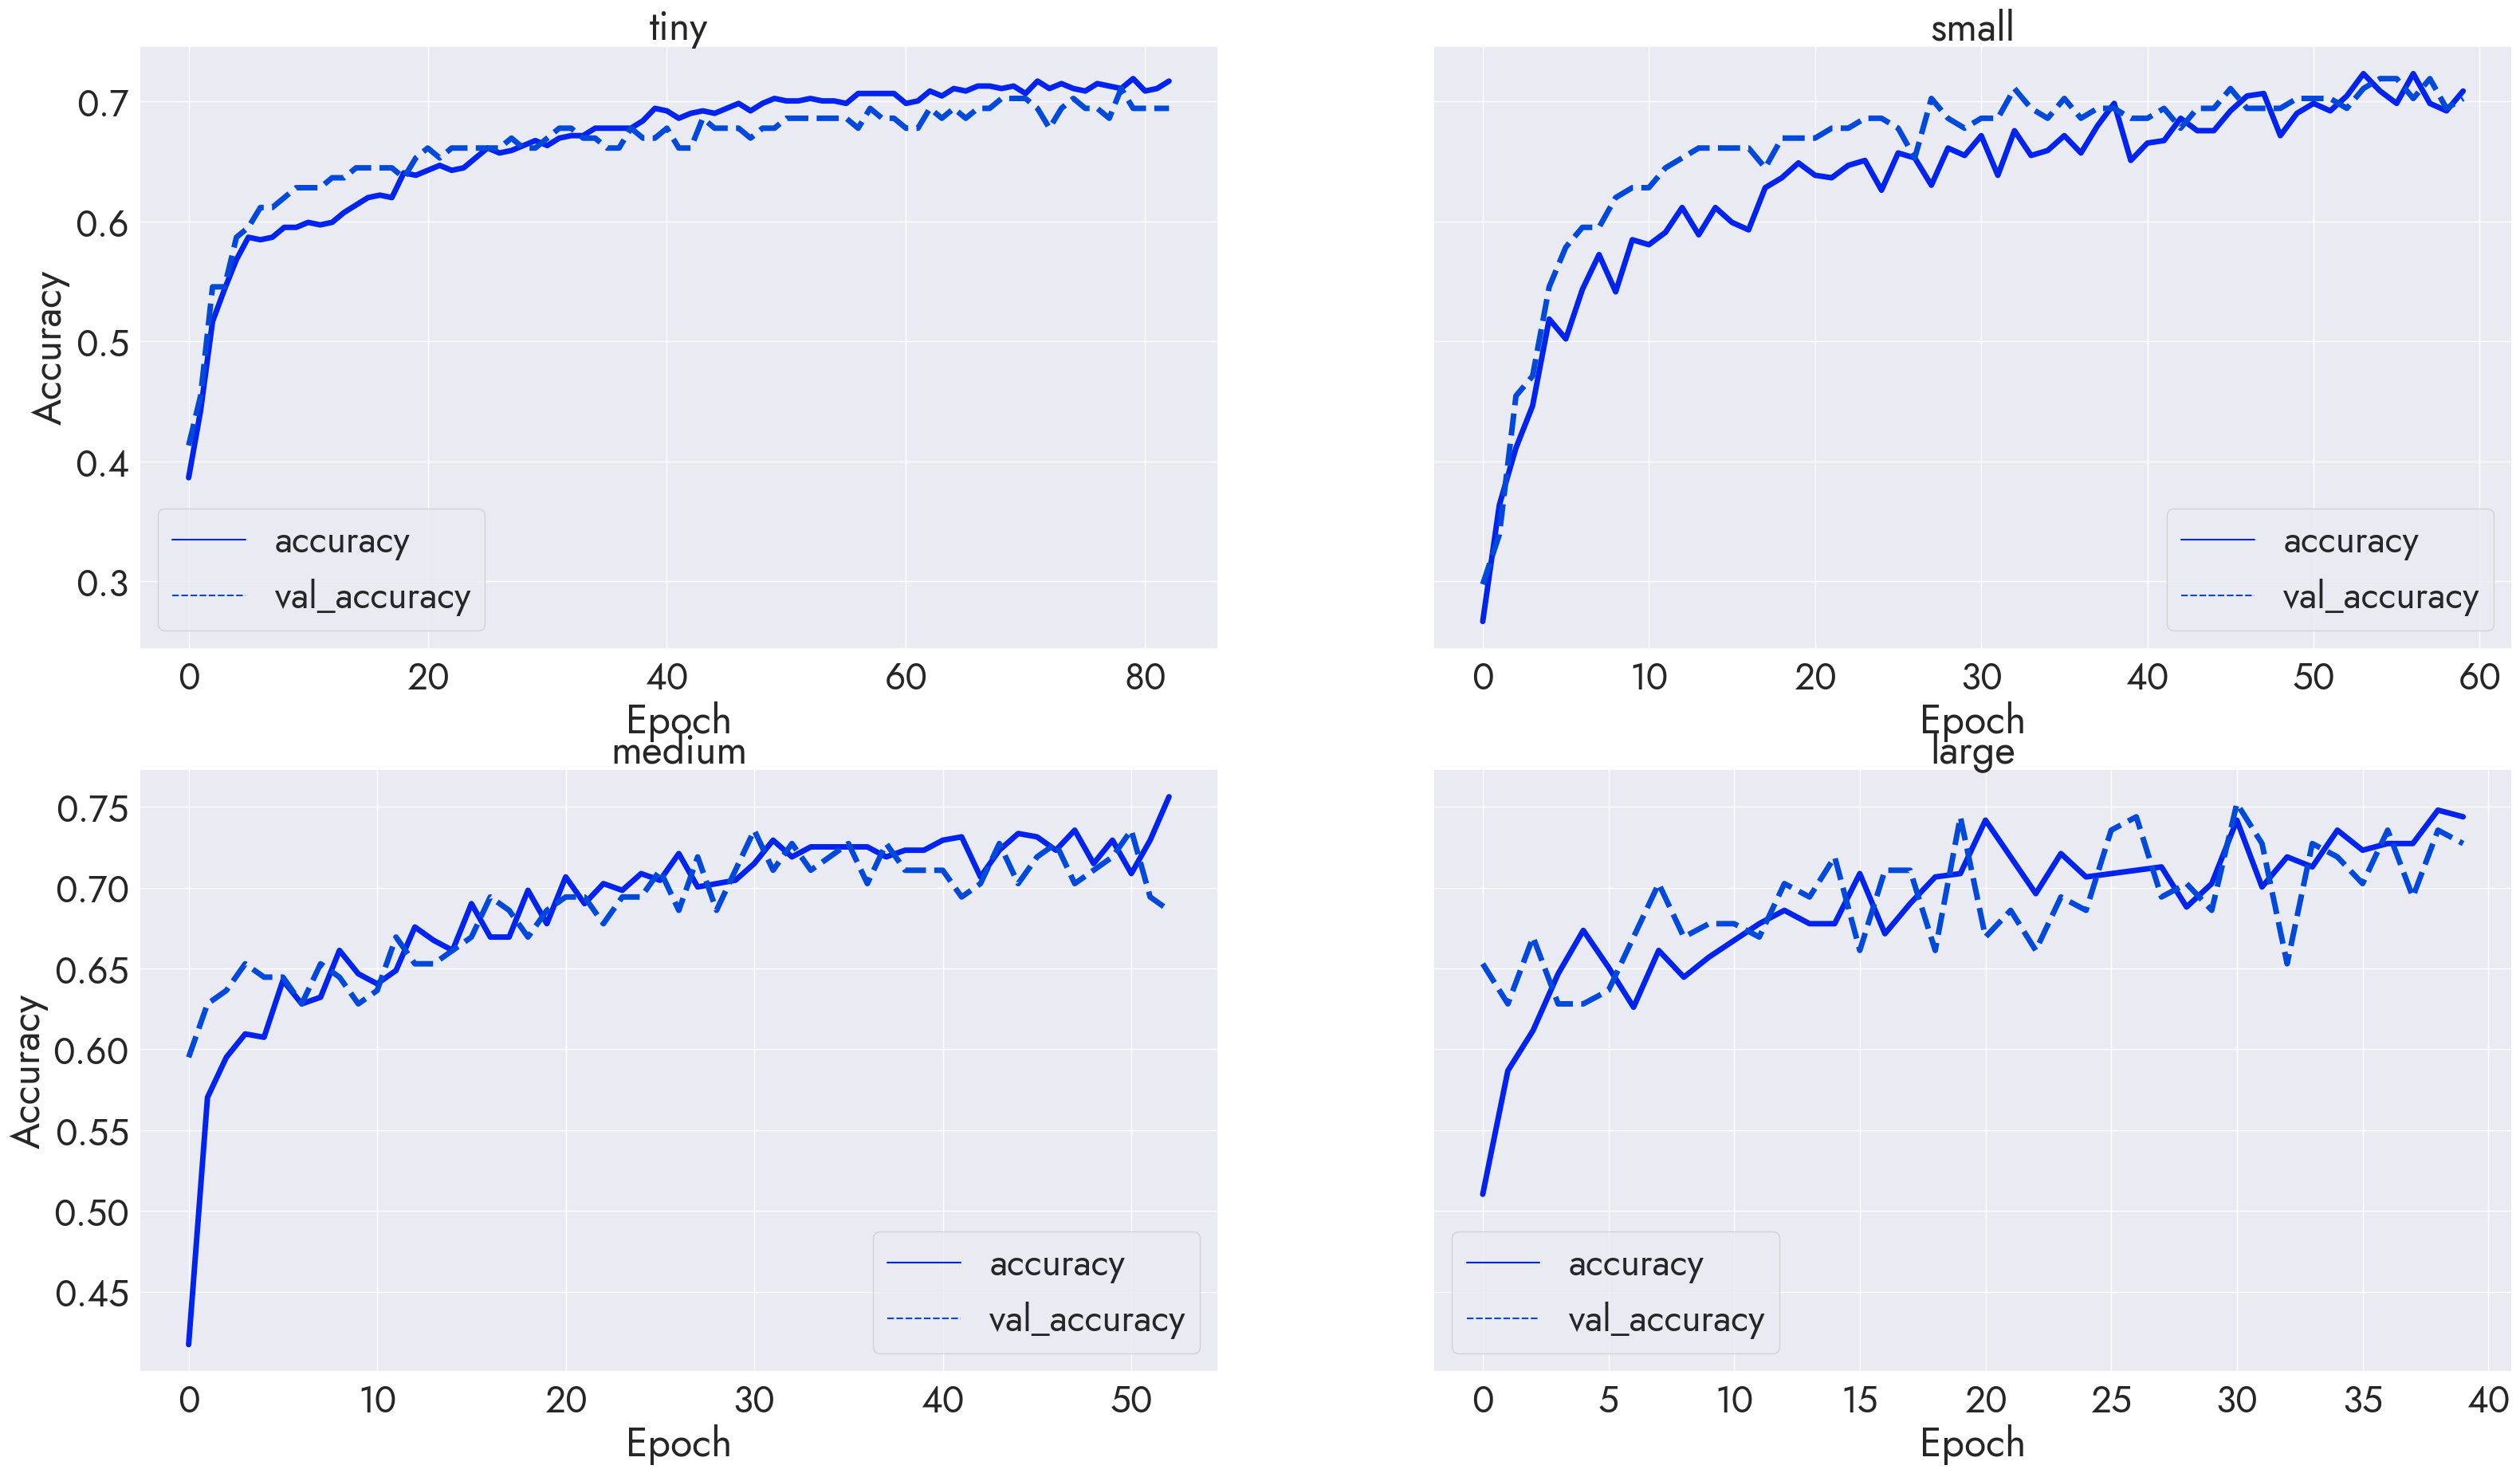

In [54]:
fig, axs = plt.subplots(2, 2, sharey='row')

for history_name, ax in zip(size_histories, axs.flat):
    sns.lineplot(data=pd.DataFrame(size_histories[history_name])[['accuracy', 'val_accuracy']], linewidth=5, ax=ax)

    ax.set_title(history_name)
    ax.set_xlabel('Epoch')
    ax.set_ylabel('Accuracy')

In [55]:
fig.savefig(f'{VISUAL_PATH}/fixed_history.png', transparent=True)

Выберем в качестве основной модель с наибольшей точностью предсказаний

In [56]:
fixed_model = large_model

### Диаграммы
Визуализируем полученные результаты - начнём с определения предсказанных значений

In [57]:
test_predict = fixed_model.predict(test_features, batch_size=BATCH_SIZE, verbose=2);

10/10 - 0s - 106ms/epoch - 11ms/step


Массив предсказанных значений состоит из весов, с каким шансом к какой группе относится конкретное наблюдение.
Конвертируем его в вид dummy-переменных

In [58]:
test_predict = np.where(test_predict == test_predict.max(axis=1).reshape(-1, 1), 1, 0).astype('int8')

Посмотрим распределение предсказаний модели по группам

In [59]:
fixed_distribution = (
    pd.pivot_table(
        data=pd.concat(
            [
                pd.from_dummies(pd.DataFrame(test_target)).rename(columns={'': 'target'}),
                pd.DataFrame(test_predict),
            ],
            axis=1
        ),
        columns='target',
        aggfunc='sum',
    )
    .rename(
        index=dict(zip(range(4), groups)),
        columns=dict(zip(range(4), groups)),
    )
)

fixed_distribution.head()

target,Low income,Lower-middle income,Upper-middle income,High income
Low income,41,15,6,0
Lower-middle income,4,18,9,0
Upper-middle income,0,1,12,10
High income,0,1,11,23


Выведем это на тепловую карту

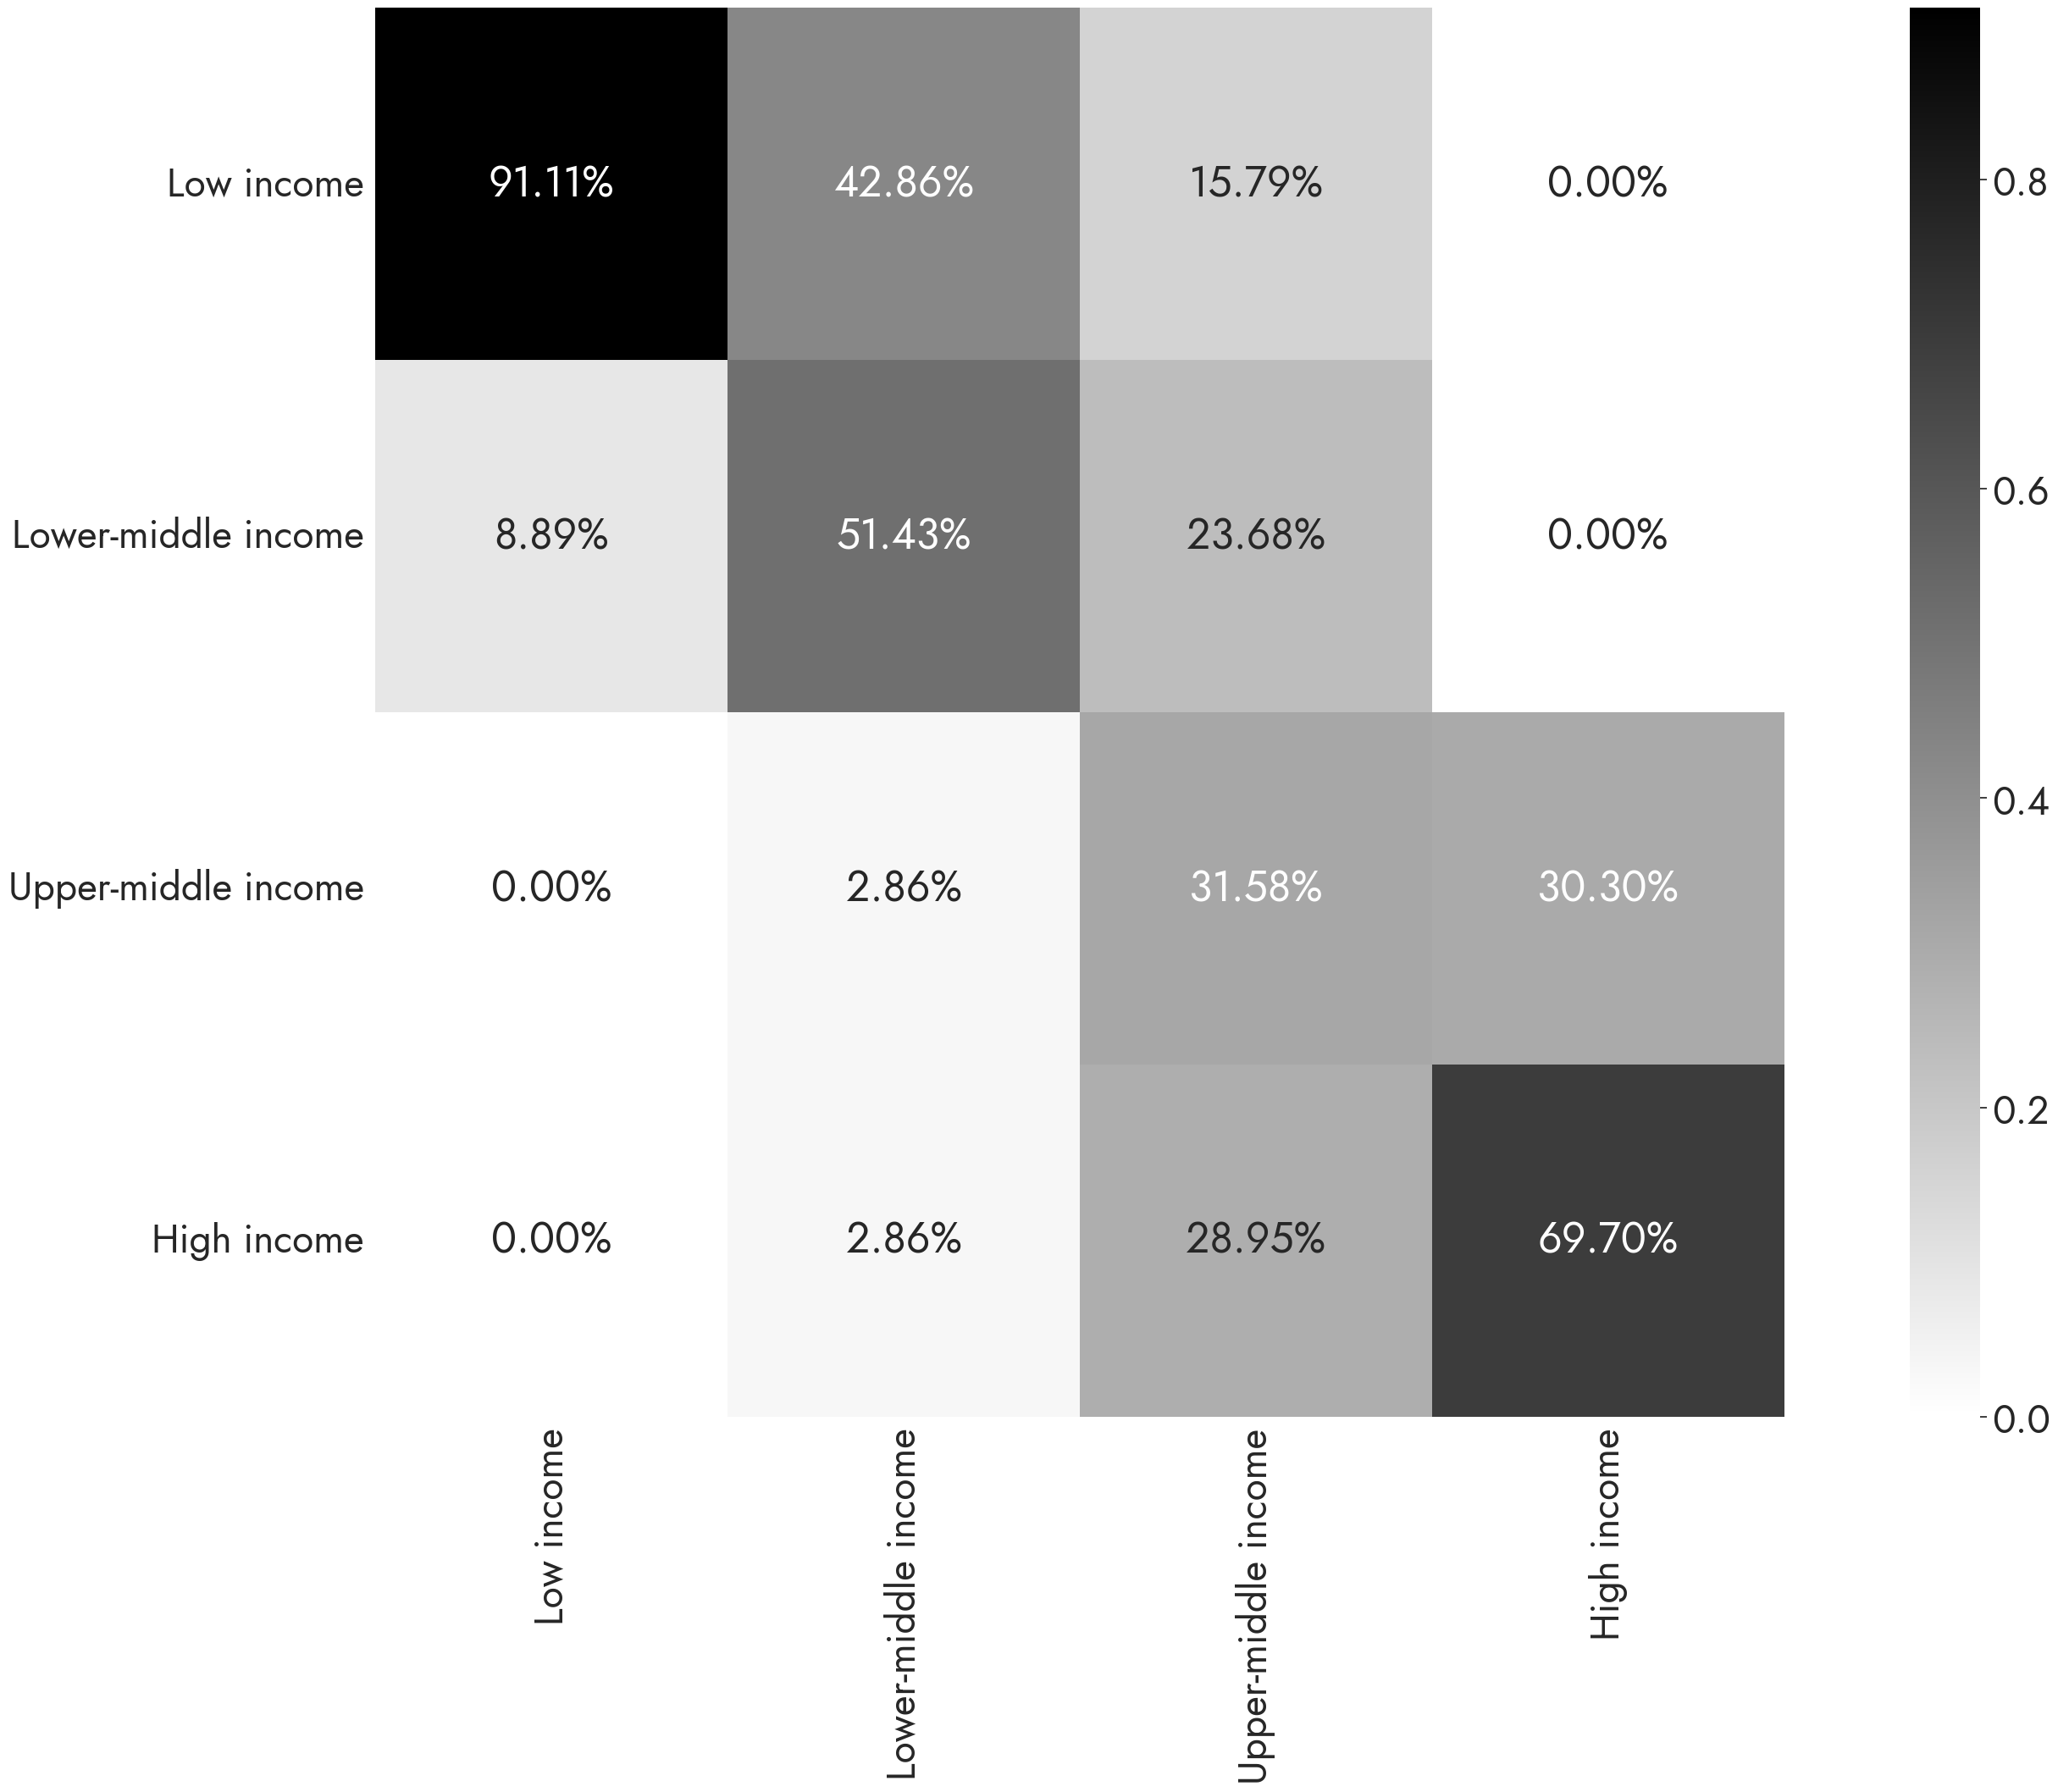

In [60]:
fixed_plot_distribution = sns.heatmap(fixed_distribution / fixed_distribution.sum(), cmap='gray_r', annot=True, fmt='.2%', square=True)

fixed_plot_distribution.set_xlabel(None);

In [61]:
fixed_plot_distribution.figure.savefig(f'{VISUAL_PATH}/fixed_distribution.png', transparent=True)

Как видно по сводной таблице и по графику, в большинстве случаев модель верно определяет группу.
Теперь визуализируем распределение ошибок в модели

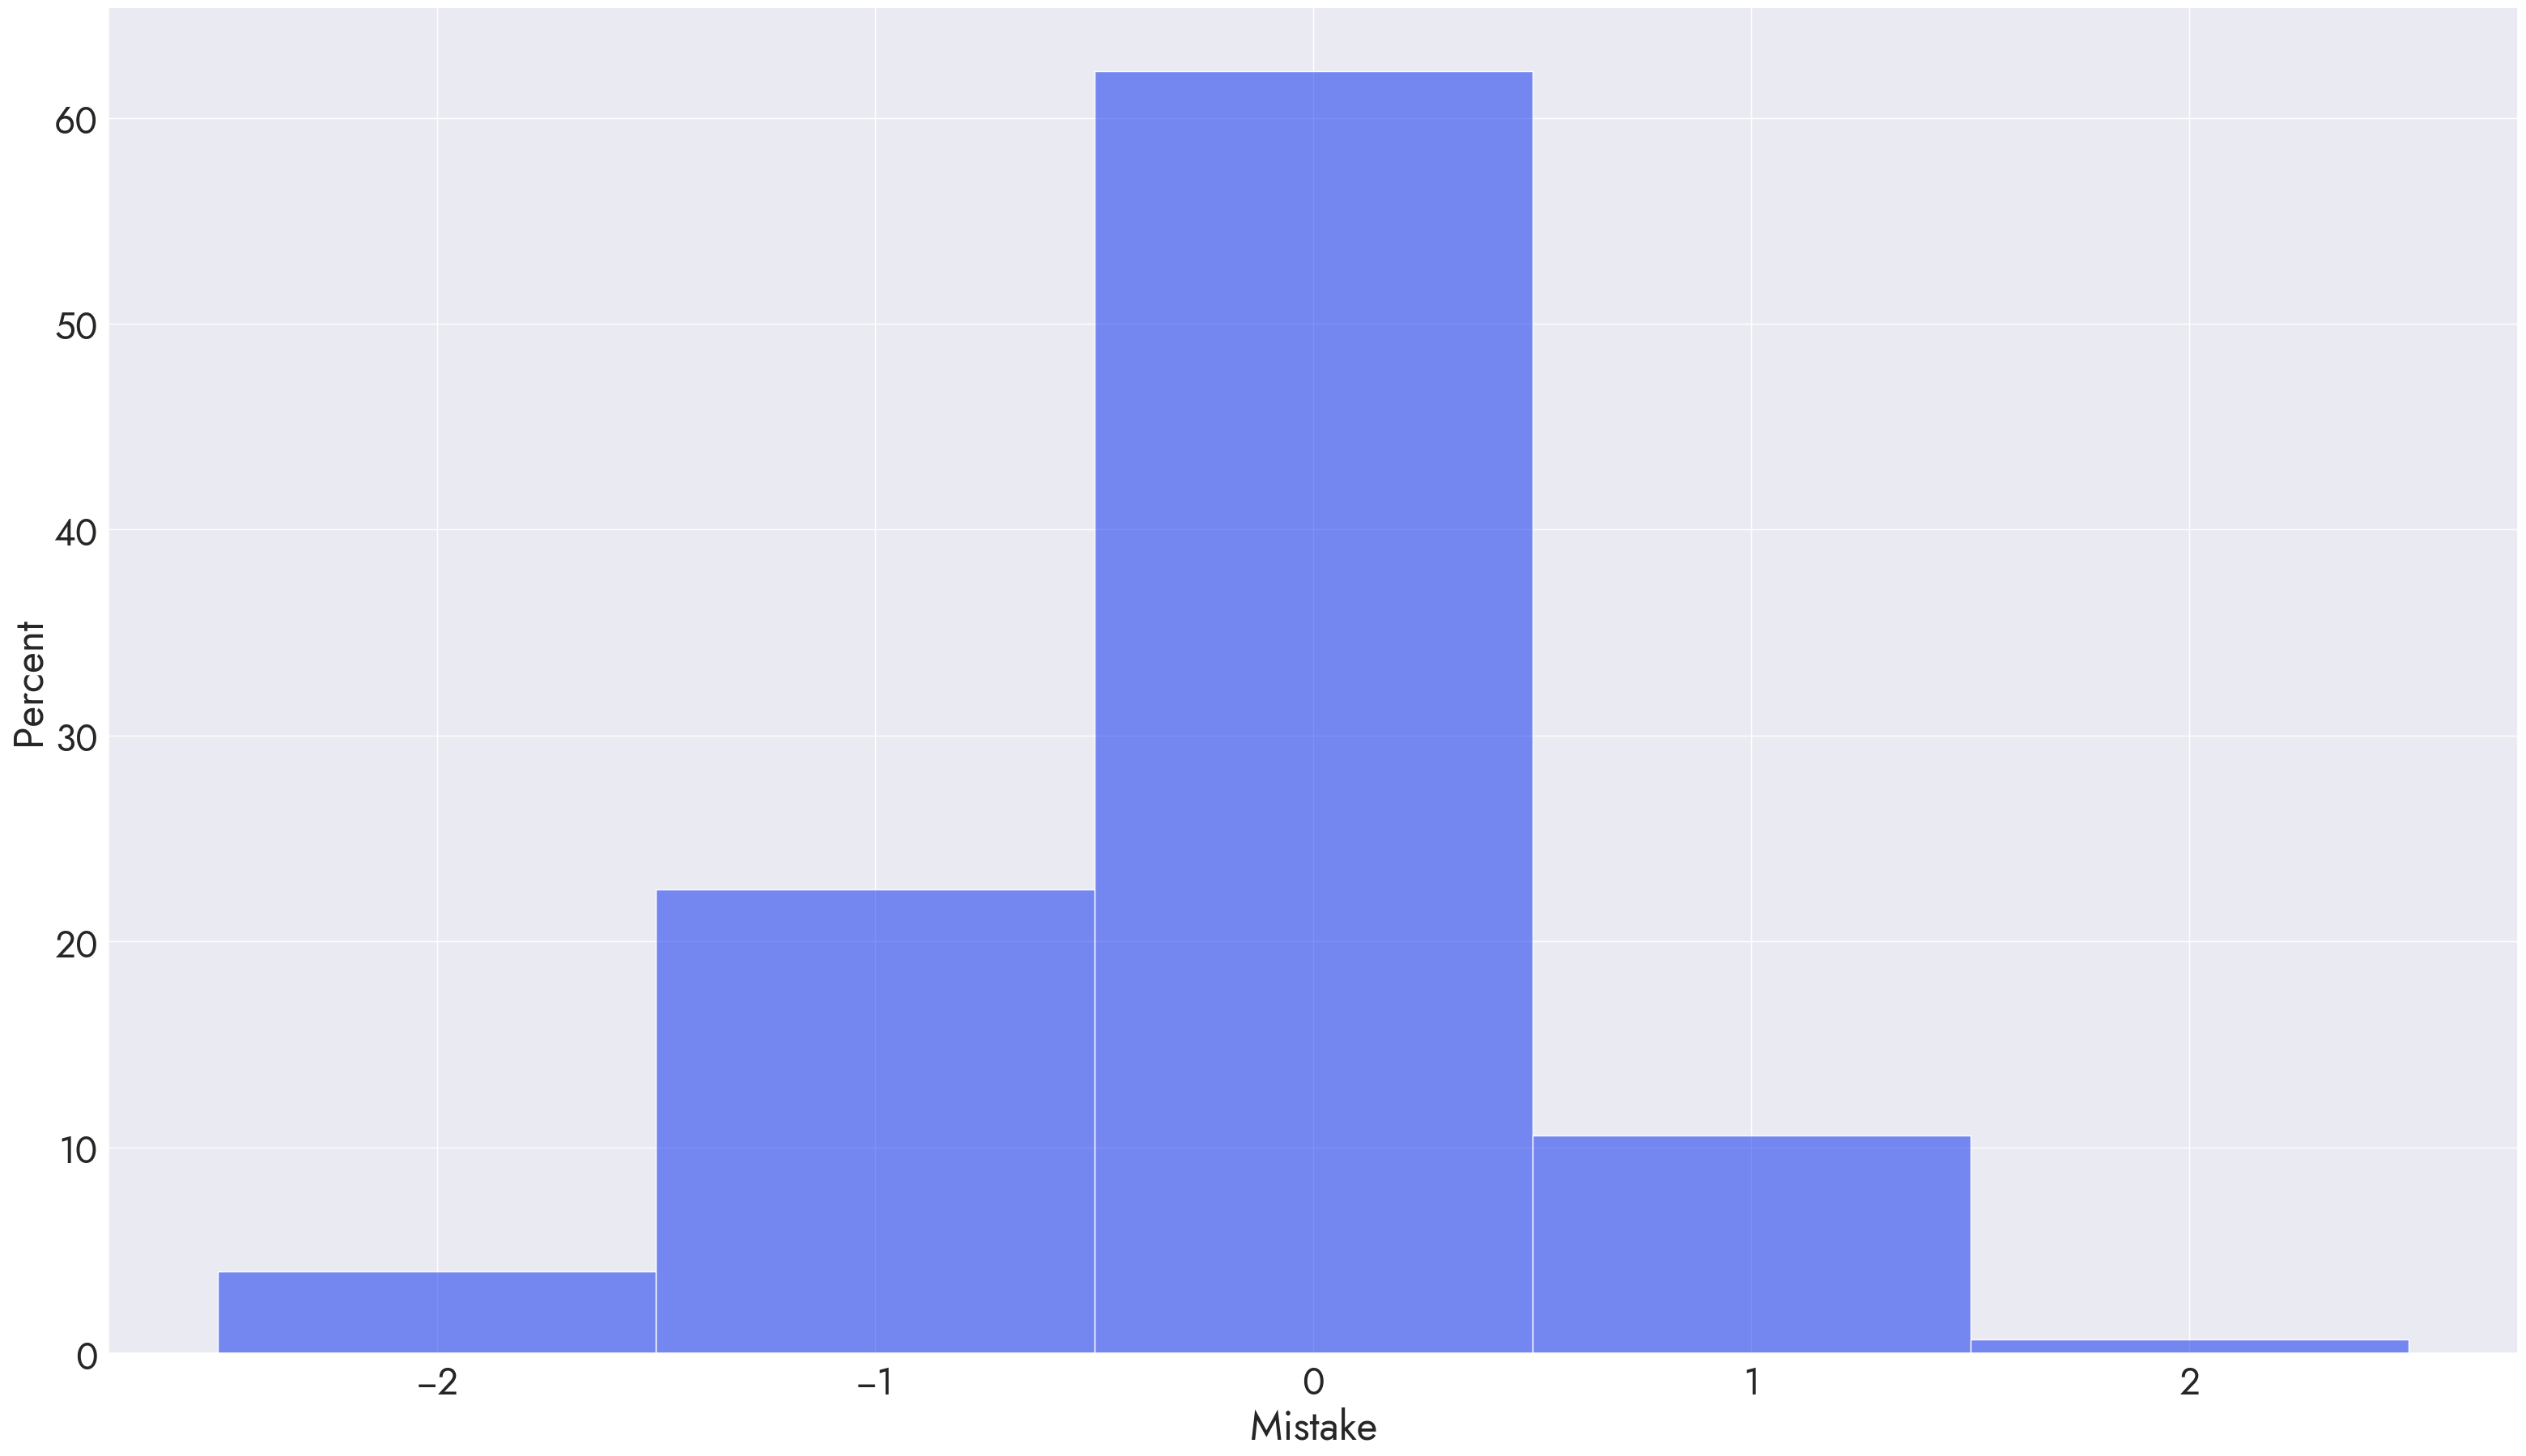

In [62]:
fixed_plot_mistakes = sns.histplot(data=pd.from_dummies(pd.DataFrame(test_predict)) - pd.from_dummies(pd.DataFrame(test_target)), stat='percent', legend=False, discrete=True)

fixed_plot_mistakes.set_xlabel('Mistake');

Большинство наблюдений было предсказано правильно - при этом распределение ошибок имеет нормальный вид, в среднем модель ошибается в рамках соседних групп

In [63]:
fixed_plot_mistakes.figure.savefig(f'{VISUAL_PATH}/fixed_mistakes.png', transparent=True)